First of all, I import the libraries which I need for this project:

In [ ]:
import numpy as np, pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt, seaborn as sns
import scipy
import warnings
import plotly.express as px
from itertools import product
import statsmodels.api as sm
import datetime
from tqdm import tqdm
from google.colab import files
import io
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# 1. Data Cleaning

In [ ]:
# Load the data set
df = pd.read_csv('Covid19-vaccination.csv')
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


Look the summary of the columns in df

In [ ]:
df.info(verbose=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63006 entries, 0 to 63005
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   location                             63006 non-null  object 
 1   iso_code                             63006 non-null  object 
 2   date                                 63006 non-null  object 
 3   total_vaccinations                   35729 non-null  float64
 4   people_vaccinated                    34123 non-null  float64
 5   people_fully_vaccinated              31153 non-null  float64
 6   total_boosters                       6613 non-null   float64
 7   daily_vaccinations_raw               29923 non-null  float64
 8   daily_vaccinations                   62680 non-null  float64
 9   total_vaccinations_per_hundred       35729 non-null  float64
 10  people_vaccinated_per_hundred        34123 non-null  float64
 11  people_fully_vaccinated_per_

Let's check out if we have any missing data in our dataset.

In [ ]:
# Check out if we have any missing data in our dataset.
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

As can be seen, there is quite much missing data. Let's drop total_vaccinations missing data, as without this value any raw doesn't make much sense.

In [ ]:
df = df.drop(df[df.total_vaccinations.isna()].index)
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

# Fill missing value

In [ ]:
check_df = df.drop(df[df.people_vaccinated.isna()].index)
check_df[['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters']][0:10]

,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters
0,0.0,0.0,NaN,NaN
6,8200.0,8200.0,NaN,NaN
22,54000.0,54000.0,NaN,NaN
44,120000.0,120000.0,NaN,NaN
59,240000.0,240000.0,NaN,NaN
78,504502.0,448878.0,55624.0,NaN
87,547901.0,470341.0,77560.0,NaN
91,573277.0,476367.0,96910.0,NaN
93,590454.0,479372.0,111082.0,NaN
94,593313.0,479574.0,113739.0,NaN


As we can see from the data, the values of 'total_vaccinations' = 'people_vaccinated'+'people_fully_vaccinated'+'total_boosters' when missing values of 'people_fully_vaccinated' and 'total_boosters' are 0.
Let's check the correlation to understand if it is so.

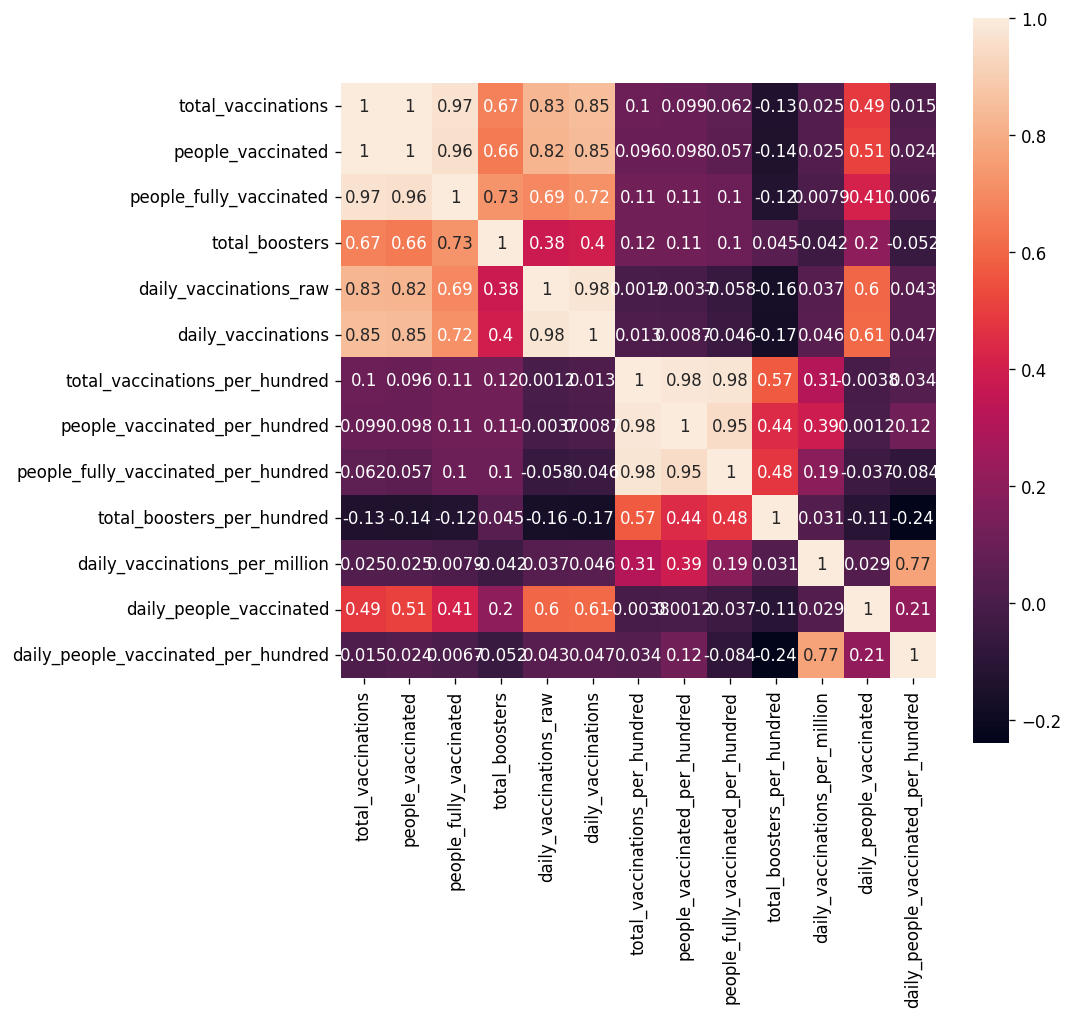

In [ ]:
# correlation matrix
plt.subplots(figsize=(8, 8))
sns.heatmap(check_df.corr(), annot=True, square=True)
plt.show()

From the correlation matrix, we can see'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters' are very corrlated with each other as we expected, then I replace missing values of 'people_fully_vaccinated' and 'total_boosters' with 0; then, fill the missing values of people_vaccinated based on the equation. 

In [ ]:
# Fill 0 for 'people_fully_vaccinated', 'total_boosters' 
df.people_fully_vaccinated = df.people_fully_vaccinated.fillna(0)
df.total_boosters = df.total_boosters.fillna(0)
# Fill people_vaccinated 
df.people_vaccinated = df.people_vaccinated.fillna(df.total_vaccinations - df.people_fully_vaccinated - df.total_boosters)

# Check # nan items in people_vaccinated
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                          0
people_fully_vaccinated                    0
total_boosters                             0
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

For the rest of the columns which contain numbers, let's check the hypothesis that these columns distributions are the same. We apply normalization(avoid scaling problem) and Mann-Whitney U test, check the p_values. 
- p <= 0.05: reject H0, different distribution.
- p > 0.05: fail to reject H0, same distribution.

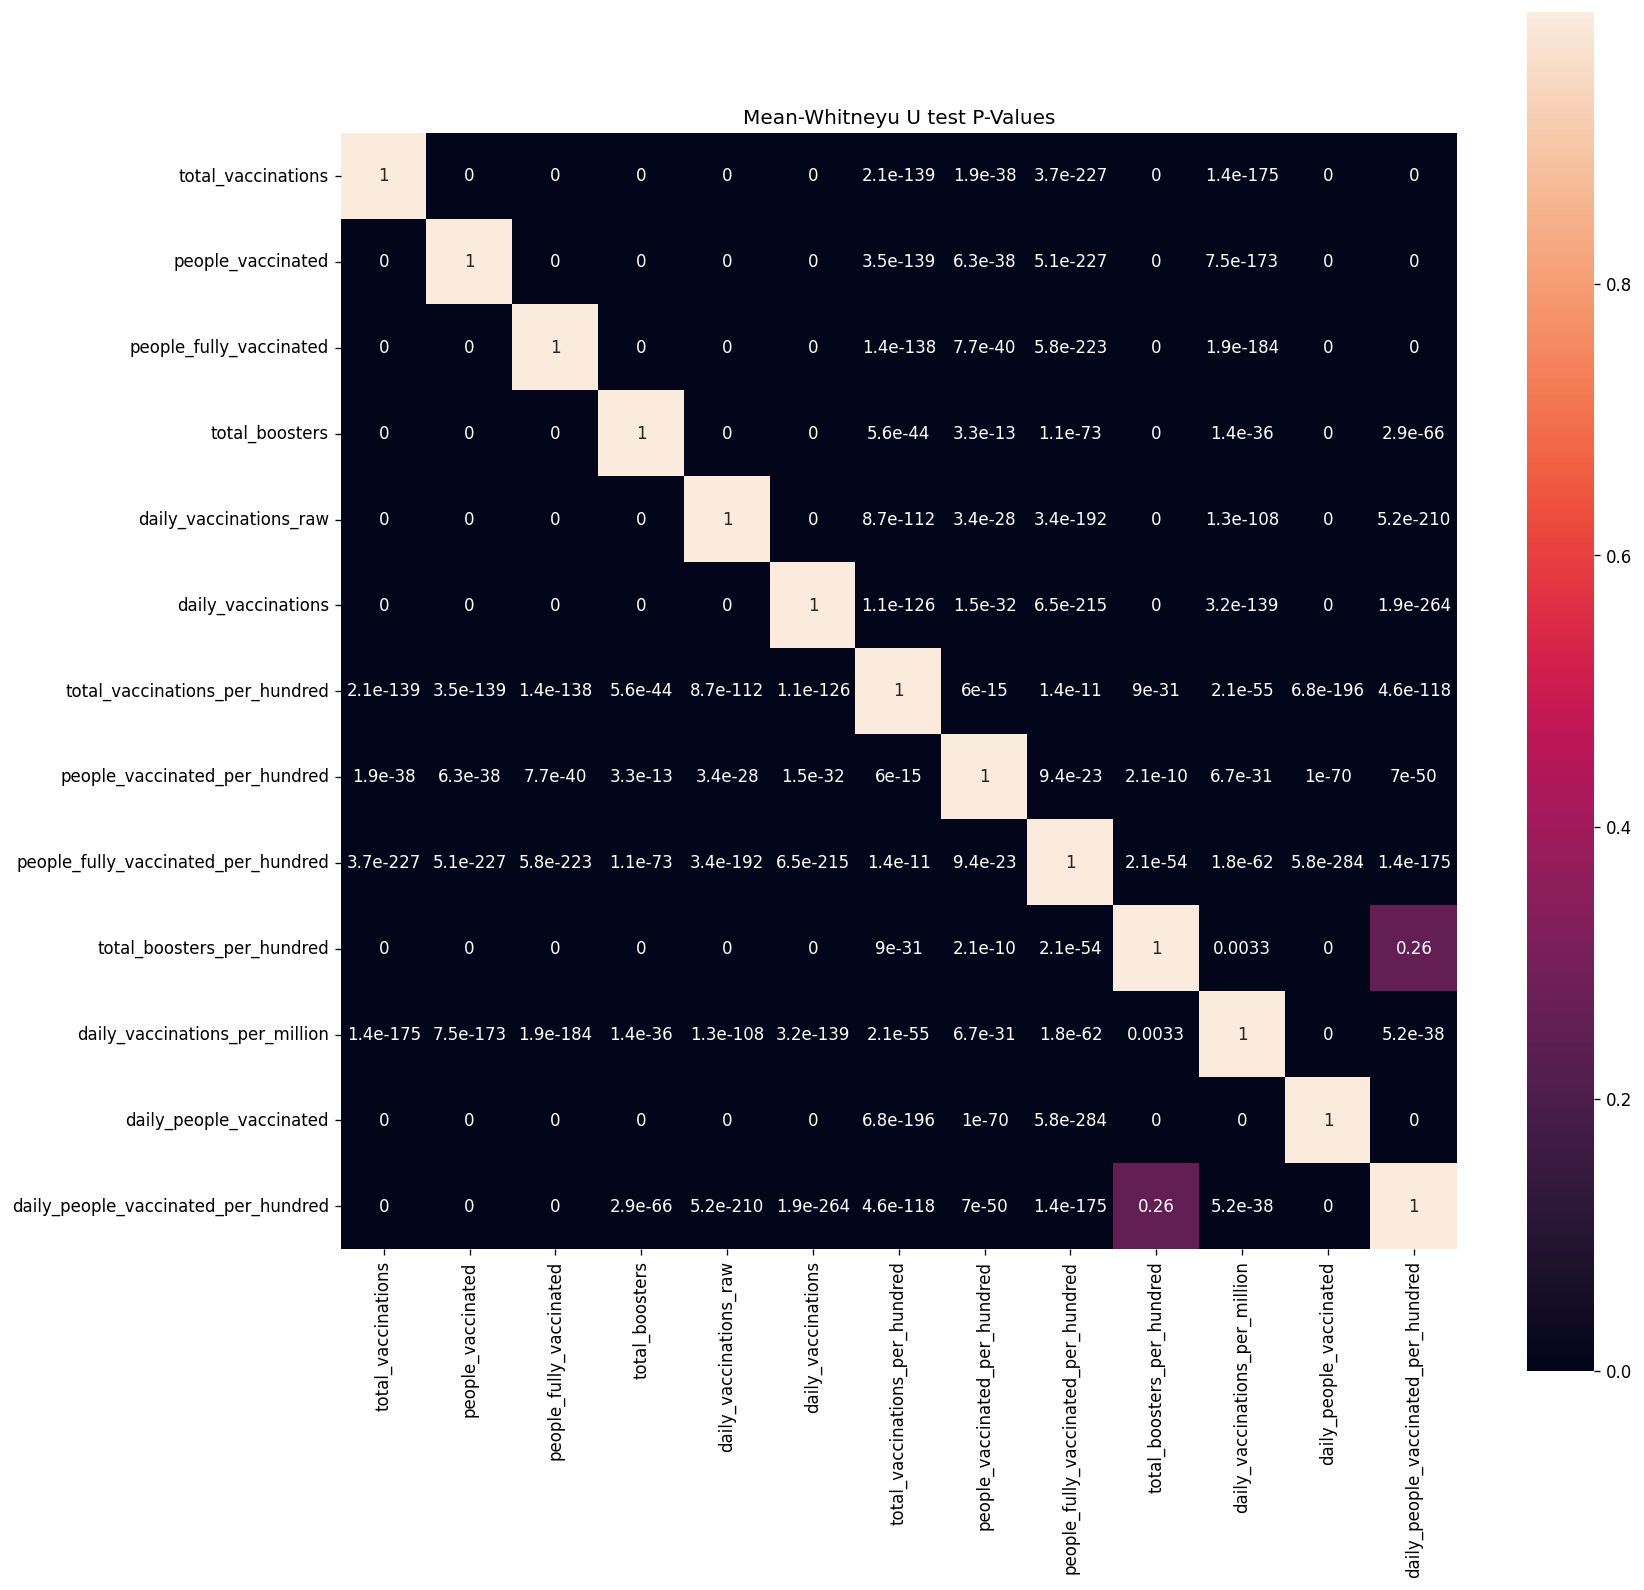

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
list_columns = check_df.columns[3:]
temp = []
for i in list_columns:
  temp2 = []
  temp_scale = StandardScaler()
  temp_scale2 = StandardScaler()
  for j in list_columns:
    check_dfi = check_df[i].dropna() # Drop NA item for the feature column before do Mann-Whiney U test each time.
    check_dfj = check_df[j].dropna()
    temp2.append(mannwhitneyu(temp_scale.fit_transform(check_dfi.values.reshape(-1,1)),
                              temp_scale2.fit_transform(check_dfj.values.reshape(-1,1)), alternative='two-sided')[1])
  temp.append(temp2)

plt.subplots(figsize=(15, 15))
sns.heatmap(temp, annot=True, square=True, yticklabels = list_columns, xticklabels = list_columns)
plt.title('Mean-Whitneyu U test P-Values')
plt.show()

After Mann-Whitney U test, check the p_values. daily_people_vaccinated_per_hundred are not greatly correlates with total_boosters_per_hundred with value of -0.24, although p-values > 0.05, reject H0, we still cannot say they have same distribution. 

The rest of p-values < 0.05, then we conclude rest of the features have different distribution. Thus, we fill missing values with 0.

In [ ]:
df.daily_vaccinations_raw = df.daily_vaccinations_raw.fillna(0)
df.daily_vaccinations = df.daily_vaccinations.fillna(0)
df.total_vaccinations_per_hundred = df.total_vaccinations_per_hundred.fillna(0)
df.people_vaccinated_per_hundred  = df.people_vaccinated_per_hundred.fillna(0)
df.people_fully_vaccinated_per_hundred = df.people_fully_vaccinated_per_hundred.fillna(0)
df.total_boosters_per_hundred  = df.total_boosters_per_hundred.fillna(0)
df.daily_vaccinations_per_million = df.daily_vaccinations_per_million.fillna(0)
df.daily_people_vaccinated = df.daily_people_vaccinated.fillna(0)
df.daily_people_vaccinated_per_hundred = df.daily_people_vaccinated_per_hundred.fillna(0)

In [ ]:
# Check # nan items in each column
df.isna().sum() # Data cleaning done

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

# 2

# 1. Which location have the largest number of people who fully vaccinated?

The COVID-19 vaccine has been undergoing clinical trials in mid-to-late 2020, and was officially launched and used in December 2020, and was implemented in more and more countries/regions over time. Fully vaccinated people are those who received all doses prescribed by the vaccination protocol. Regardless of population, which location have the largest number of people who fully vaccinated?


In [ ]:
# Showing unique country name.
df['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethi

,location,people_fully_vaccinated
0,World,3.287201e+09
1,Asia,2.176438e+09
2,Upper middle income,1.615388e+09
3,China,1.076308e+09
4,Lower middle income,8.398658e+08
5,High income,8.135848e+08
6,Europe,4.276655e+08
7,India,4.010692e+08
8,North America,3.224723e+08
9,European Union,2.981220e+08


Text(0, 0.5, 'Amount of people fullly vaccinated (in millions)')

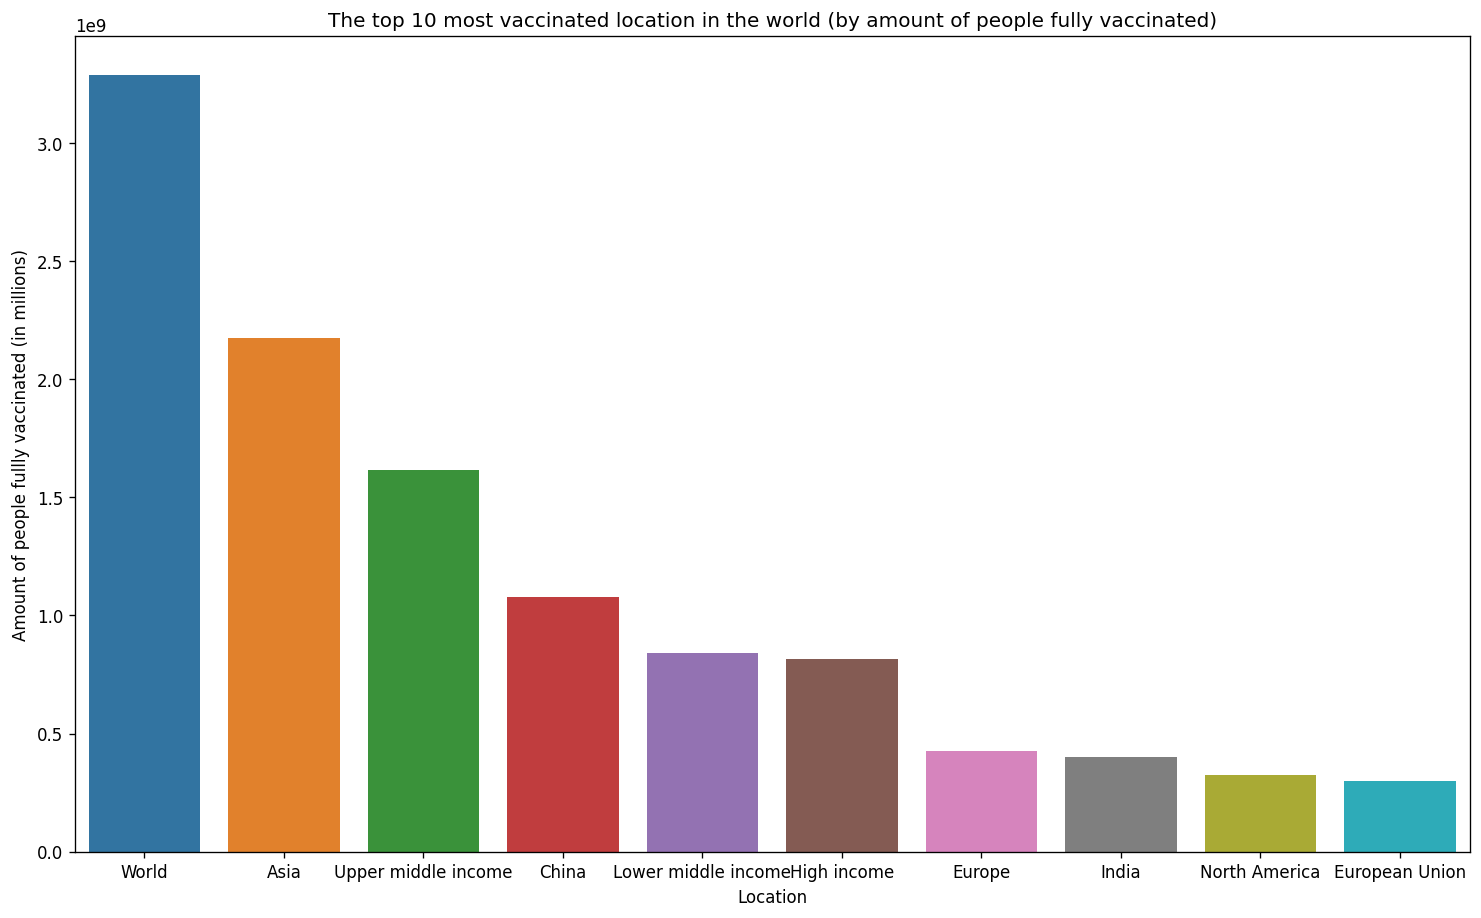

In [ ]:
# Grouping the data by location and then sorting the data by the max value from highest to lowest
top_people_fully_vaccinated = df.groupby('location').people_fully_vaccinated.max().sort_values(ascending=False)
people_fully_vaccinated_f = top_people_fully_vaccinated.dropna(axis=0).reset_index() # Dropping NaN values

display(people_fully_vaccinated_f[0:10])

# Plotting a barplot for data viz using matplotlib and seaborn
plt.figure(figsize=(15, 9))
plt.title('The top 10 most vaccinated location in the world (by amount of people fully vaccinated)')
sns.barplot(x=people_fully_vaccinated_f.location[0:10], y=people_fully_vaccinated_f['people_fully_vaccinated'])
plt.xlabel('Location')
plt.ylabel('Amount of people fullly vaccinated (in millions)')

World is the sum of all number of fully vaccinated people, so it is in the top 1 in the plot. Asia has the largest population among seven continents, which make sense to list the top 2 in the plot. China is the country that has the largest population in the world; then, it lists as top 4. Europe, North America and European Union list as top 7, 9, 10 does not mean most people in that location do not dully vaccinate, just because of the small number of people compared with other locations. India has a large population but does not list in the top 5; maybe they are a vaccine shortage.

# 2.Plotting this data to see the progression in people_fully_vaccinated over time


,location,date,people_fully_vaccinated
18750,Lower middle income,2021-01-12,0.0
18751,Lower middle income,2021-01-15,0.0
18752,Lower middle income,2021-01-16,0.0
18753,Lower middle income,2021-01-17,0.0
18754,Lower middle income,2021-01-18,0.0
18755,Lower middle income,2021-01-19,0.0
18756,Lower middle income,2021-01-20,0.0
18757,Lower middle income,2021-01-21,0.0
18758,Lower middle income,2021-01-22,0.0
18759,Lower middle income,2021-01-23,0.0


([<matplotlib.axis.XTick at 0x7f6f8de113d0>],
 <a list of 1 Text major ticklabel objects>)

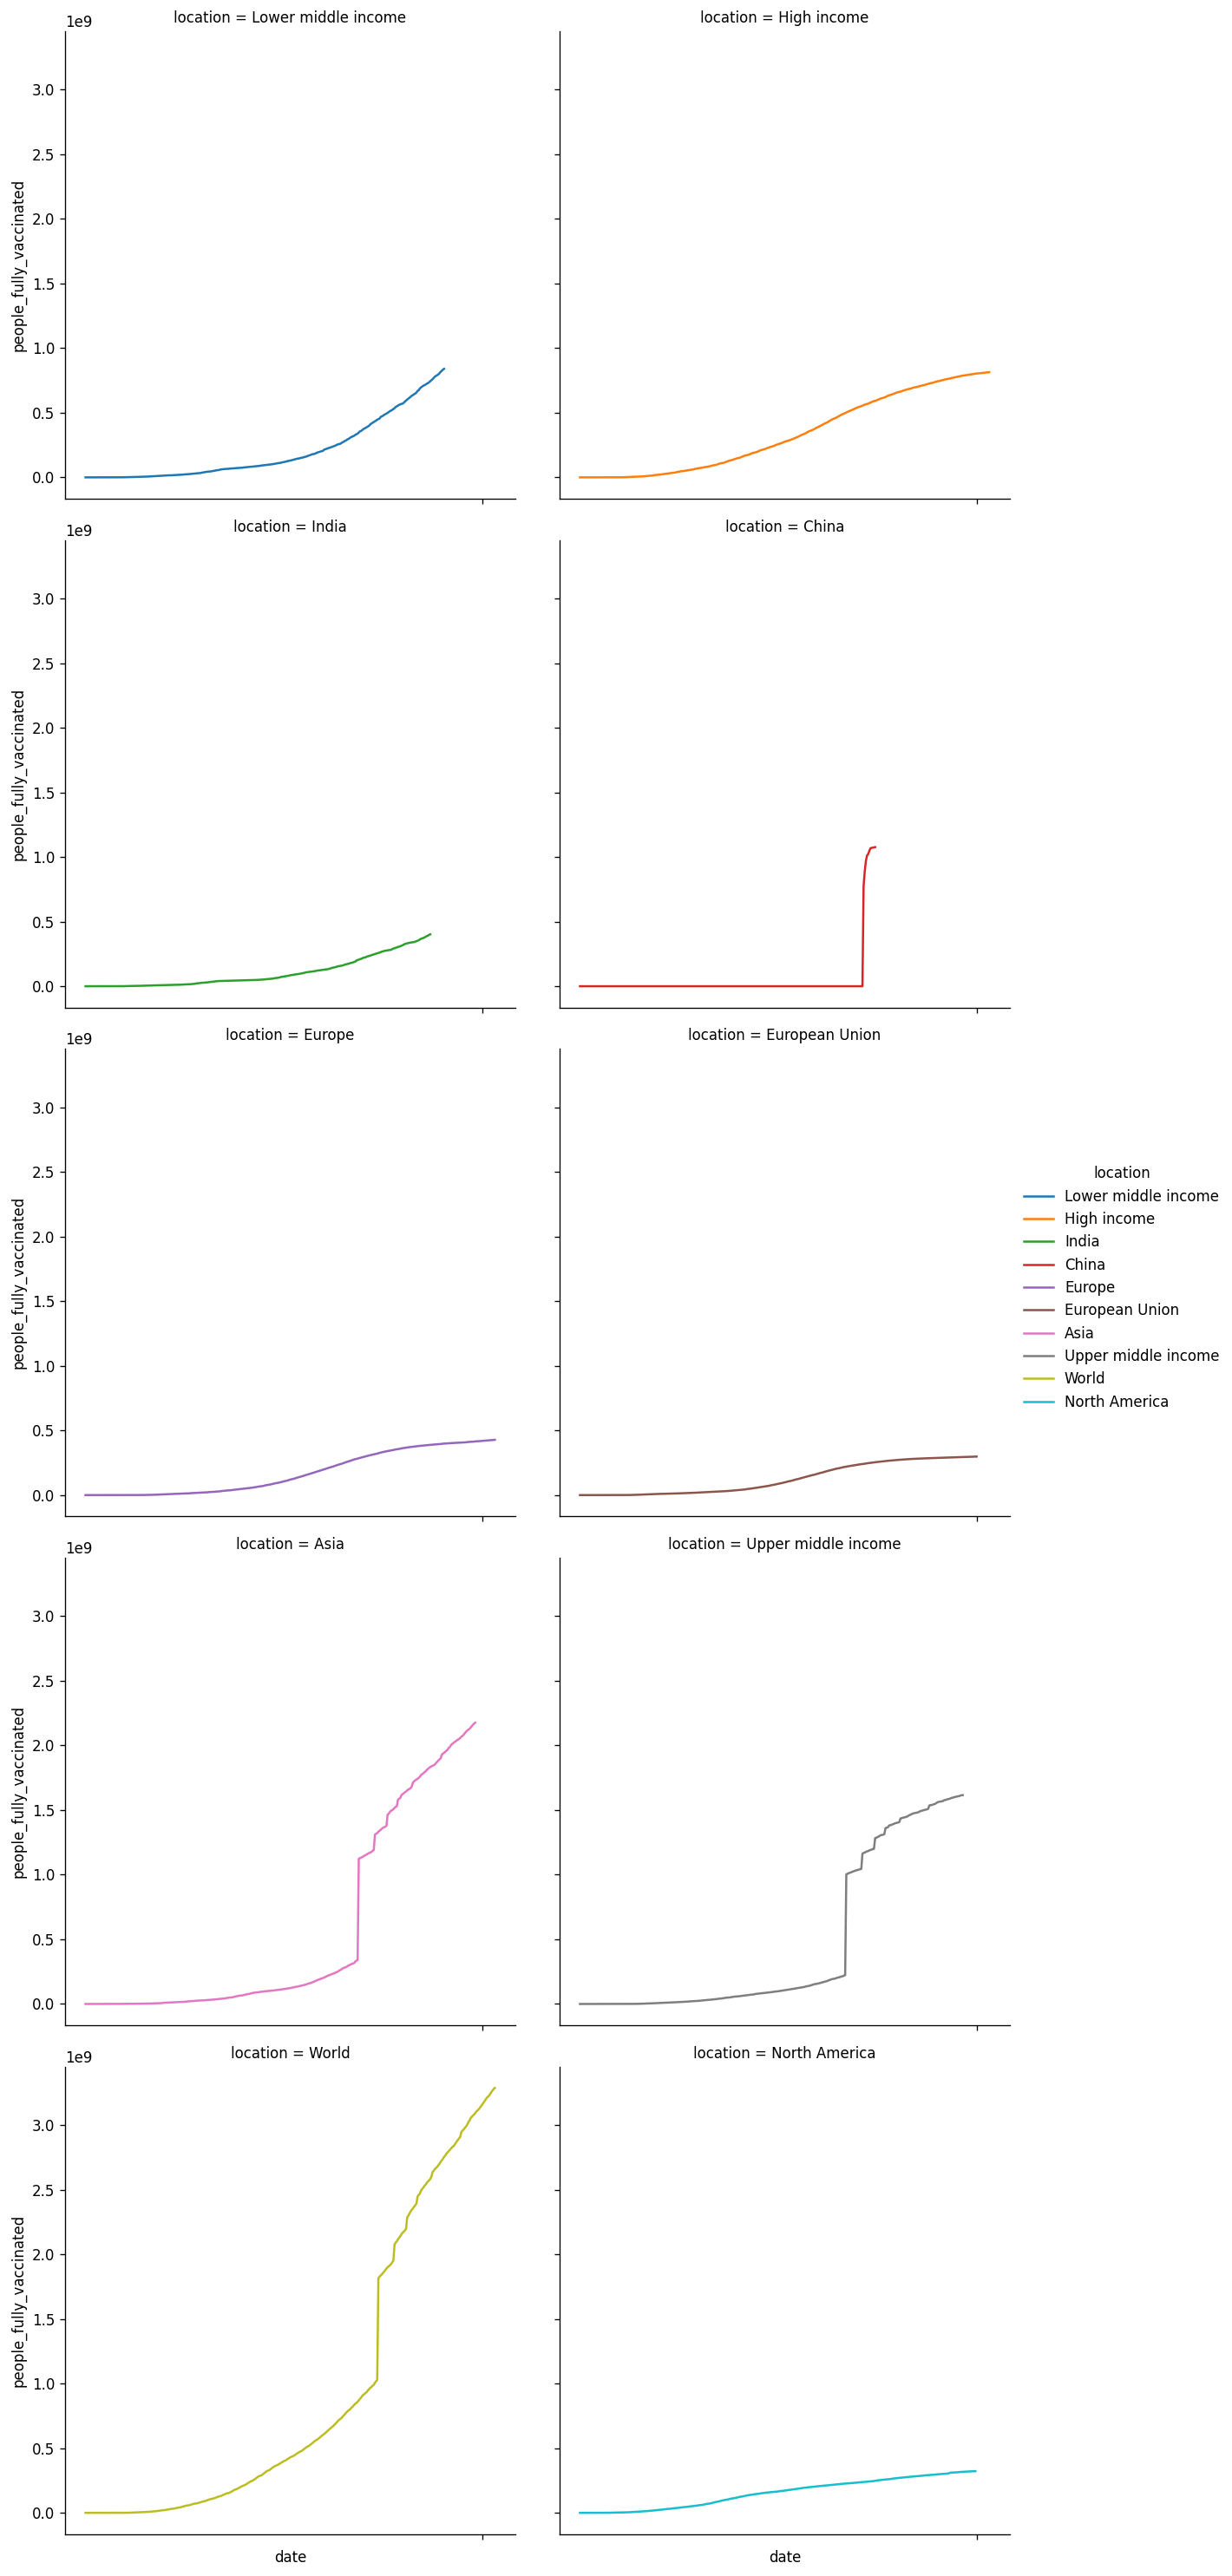

In [ ]:
# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'people_fully_vaccinated']
covid_df = df.reset_index()

# Creating a list of the aforementioned best performing locations in terms of daily vaccinations
top_10_locations = list(people_fully_vaccinated_f.location[0:10])

# Filtering and sorting the data
people_fully_vaccinated_df = covid_df[['location', 'date', 'people_fully_vaccinated']].sort_values(by='people_fully_vaccinated', ascending=True)
top_10_pfv_df = people_fully_vaccinated_df[people_fully_vaccinated_df.location.isin(top_10_locations)].dropna()

display(top_10_pfv_df[0:10]) # verifying that the filtering executed correctly

# Plotting the data in a multi faceted lineplot

#plt.figure(figsize=(18, 32))
sns.relplot(data=top_10_pfv_df, x='date', y='people_fully_vaccinated', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('')

World has increased the fully vaccinated rates slowly at the beginning and grew exponentially later on. China had a horizontal line at the start and then grew the number of fully vaccinated exponentially (almost vertically). Asia and Upper middle income aren't far behind; they increased fully vaccinated people exponentially with some fluctuations. Asia and Upper middle income aren't far behind; they increased fully vaccinated people exponentially with some fluctuations just like the line of the world. High income and Lower middle income also increased the rate faster recently, whilst India, European Union, Europe, and North America were vaccinating their populations fully slowly but steadily. 

We can also see that the lines for India, Lower middle income, and China end much earlier than any other location. There may be various reasons. Firstly, there may be some missing values for those locations. A location like China already has a very high fully vaccinate rate; they did not need to vaccinate people recently. For other locations, the reason may be shipment delay and the shortage of vaccines. 

# 3. Which locations have the best and the most effective vaccination programme?
Many countries are in the vaccination schedule at this time. Although some locations have not yet started vaccination, other locations are vaccinating people. Which locations have the best and the most effective vaccination programme?

,location,daily_vaccinations
0,World,43233999.0
1,Asia,33335736.0
2,Upper middle income,27439252.0
3,China,22424286.0
4,Lower middle income,16674499.0
5,India,10037995.0
6,High income,8397153.0
7,Europe,5128678.0
8,North America,4173238.0
9,European Union,4075834.0


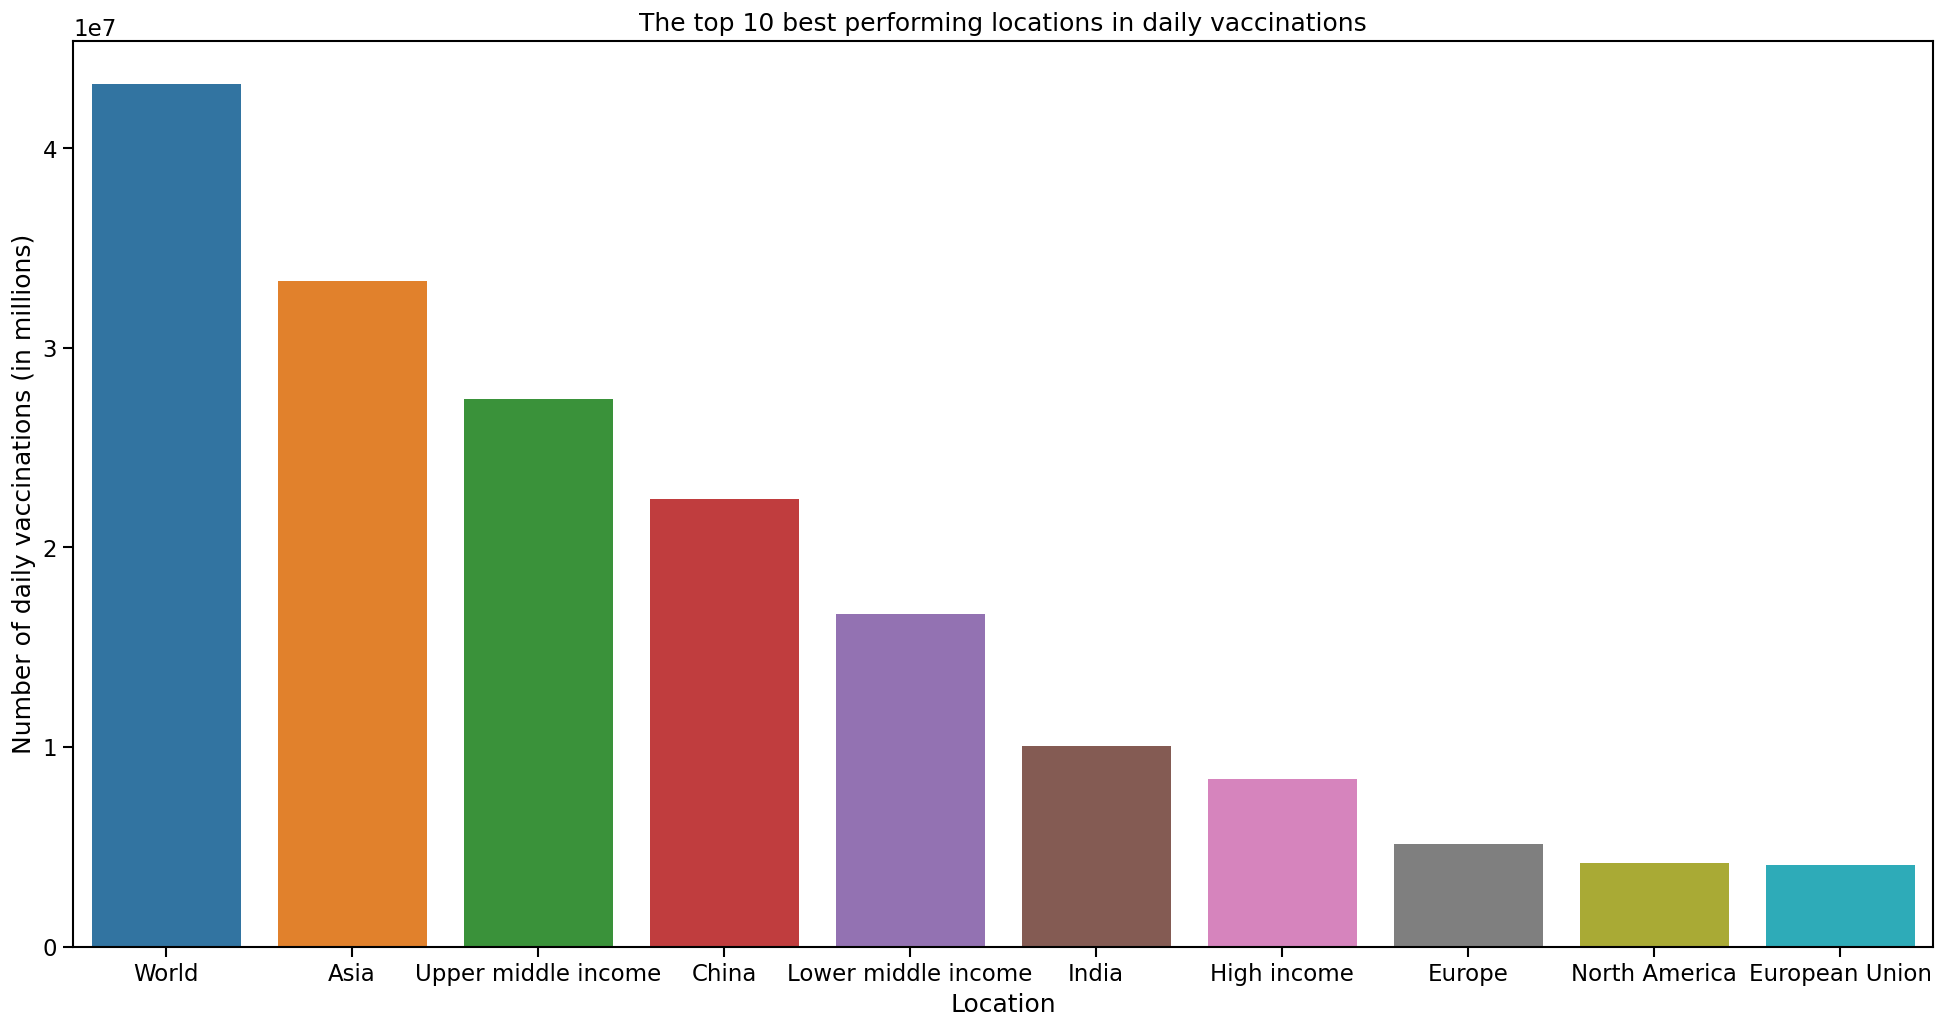

In [ ]:
# Grouping the data by location and then sorting the data by the max value from highest to lowest
top_daily = df.groupby('location').daily_vaccinations.max().sort_values(ascending=False)
top_daily_f = top_daily.dropna(axis='rows').reset_index() # Dropping NaN values

display(top_daily_f[0:10])

# Plotting the data
with sns.plotting_context('notebook', font_scale = 1.25):
    plt.figure(figsize=(20, 10))
    plt.title('The top 10 best performing locations in daily vaccinations')
    sns.barplot(x=top_daily_f.location[0:10], y=top_daily_f.daily_vaccinations[0:10])
    plt.xlabel('Location')
    plt.ylabel('Number of daily vaccinations (in millions)');

The plot is very similar to the top 10 most vaccinated location in the world (by amount of people fully vaccinated). We can see that a pattern has emerged in the best-performing countries(China India ranked very high; the pattern of countries with larger populations, more infrastructure and resources, and more vaccine supplies seems to be vaccinating rapidly, so, over time, the number of vaccines will increase. 

# 4. Plotting this data to see the progression in daily vaccinations over time

,location,date,daily_vaccinations
13155,High income,2020-12-03,0.0
13156,High income,2020-12-04,0.0
13157,High income,2020-12-05,0.0
13158,High income,2020-12-06,0.0
13159,High income,2020-12-07,0.0
13160,High income,2020-12-08,0.0
13161,High income,2020-12-09,0.0
13162,High income,2020-12-10,0.0
13163,High income,2020-12-11,0.0
13164,High income,2020-12-12,0.0


([<matplotlib.axis.XTick at 0x7f6f8be93490>],
 <a list of 1 Text major ticklabel objects>)

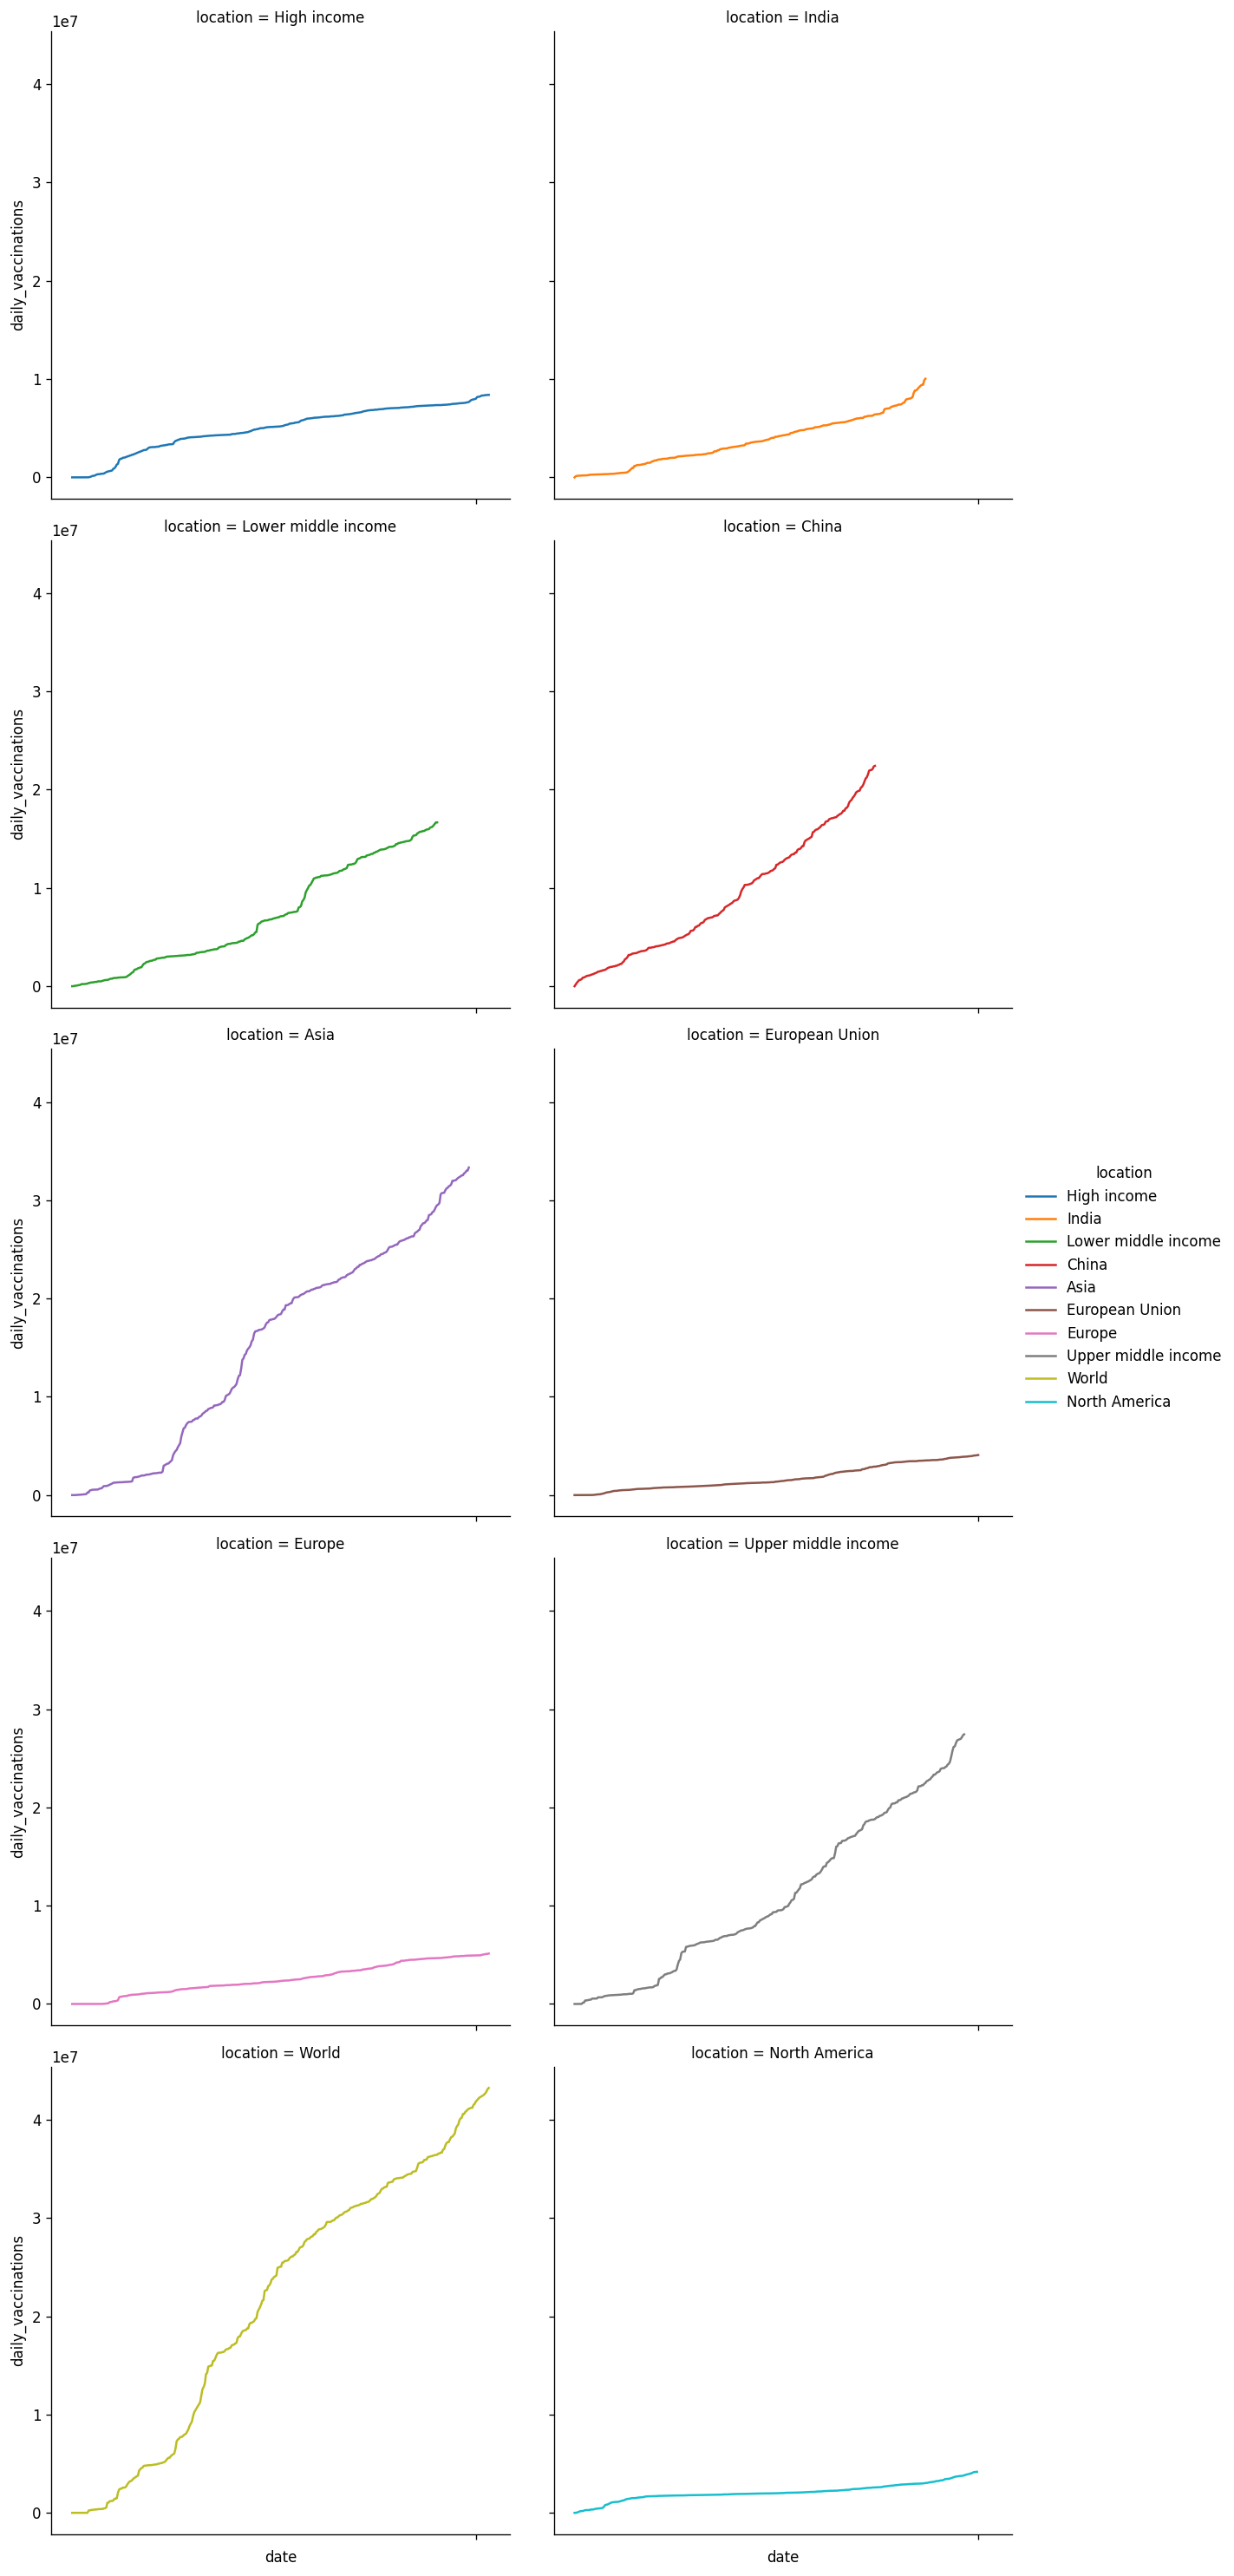

In [ ]:
# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'daily_vaccinations']
covid_df = df.reset_index()

# Creating a list of the aforementioned best performing locations in terms of daily vaccinations
top_10_locations = list(top_daily_f.location[0:10])

# Filtering and sorting the data
daily_vacc_df = covid_df[['location', 'date', 'daily_vaccinations']].sort_values(by='daily_vaccinations', ascending=True)
top_10_dv_df = daily_vacc_df[daily_vacc_df.location.isin(top_10_locations)].dropna()

display(top_10_dv_df[0:10]) # verifying that the filtering executed correctly

# Plotting the data in a multi faceted lineplot

#plt.figure(figsize=(18, 32))
sns.relplot(data=top_10_dv_df, x='date', y='daily_vaccinations', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('')

World has increased the vaccination rates linearly in recent days. China, Asia and Upper middle income also grew the vaccination rates dramatically and steadily. Lower middle income also saw big increases in their daily vaccinations, whilst the High income, India, European Union, Europe, and North America are vaccinating their populations slowly but steadily. 

We can also see that the lines for India, Lower middle income, and China end much earlier than any other location. There may be various reasons. Firstly, there may be some missing values for those locations. A location like China has a very high fully vaccinate rate did not need to vaccinate people recently. For other locations, the reason may be shipment delay and the shortage of vaccines.

# 3

We want to add a new a column named 'eid', each location would have a unique number. For example, each row for location Afghanistan lebeled as 1 in the column of eid.

In [ ]:
# Sort the df by location
df = df.sort_values('location')
# Number each item in each group from 0 to the length of that group - 1, 
# first item with for each location lebeled as 1, other row labeled as 0
df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
# Each location have a unique number by order
df['eid'] = df['eid'].cumsum()
df.head()

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
0,Afghanistan,AFG,2021-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000,1
265,Afghanistan,AFG,2021-11-14,4018197.0,3530173.0,3188609.0,0.0,0.0,36635.0,10.09,8.86,8.00,0.0,920.0,60035.0,0.151,1
220,Afghanistan,AFG,2021-09-30,2369625.0,828601.0,0.0,0.0,0.0,12999.0,5.95,2.08,0.00,0.0,326.0,1853.0,0.005,1
190,Afghanistan,AFG,2021-08-31,1979652.0,773002.0,0.0,0.0,0.0,70761.0,4.97,1.94,0.00,0.0,1776.0,224.0,0.001,1
179,Afghanistan,AFG,2021-08-20,1201286.0,770542.0,430744.0,0.0,0.0,1119.0,3.02,1.93,1.08,0.0,28.0,690.0,0.002,1


# Algorithm selections and projection approach justification
I would use the ARIMA model to project the time series of COVID-19 because ARIMA is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values. ARIMA model is simple but powerful which is enough to forecast the data we needed, which is the reason I use this model.

I would use the feature people_vaccinated(people vaccinated at least 1 dose) to fit the ARIMA model and generate three projection cases because we want to forecast the number of people who will be vaccinated in the next 50 days in two countries. The other reason is that I fill the missing value of people_vaccinated based on total_vaccinations, I think people_vaccinated have more reliable data to forecast compared with other columns which I filled missing value with 0.

I choose Canada and United States in the part because Canada is chosen by structure and I believe the United States have a similar situation with Canada in the COVID-19 pandemic. Those two countries are located very close, and use the same types of vaccinations; Compare the number of people vaccinated in these two countries would be useful and intuitional because they have extremely similar external conditions. 

# Canada

In [ ]:
print('eid of Canada is', list(df.loc[df.location == 'Canada'].eid)[0])
ndf=df.loc[df['eid'] == 38]
sndf = ndf.sort_values('date')
# Check dataframe of Canada
sndf.head()

eid of Canada is 38


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
9795,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000,38
9796,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.0,0.0,19.0,722.0,0.002,38
9797,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.0,0.0,40.0,1506.0,0.004,38
9798,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.0,0.0,64.0,2421.0,0.006,38
9799,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.0,0.0,74.0,2818.0,0.007,38


In [ ]:
# Get the values from the column where vaccination rate of Canada is stored.
val = sndf['people_vaccinated'].values
val

array([5.0000000e+00, 7.2700000e+02, 3.0160000e+03, 7.2670000e+03,
       1.1276000e+04, 1.2042000e+04, 1.2901000e+04, 2.1043000e+04,
       2.6826000e+04, 3.5503000e+04, 4.5698000e+04, 4.8744000e+04,
       4.8759000e+04, 5.2368000e+04, 5.8985000e+04, 7.2297000e+04,
       8.5687000e+04, 9.8656000e+04, 1.0526800e+05, 1.0993900e+05,
       1.1513900e+05, 1.3873800e+05, 1.5654500e+05, 1.8418300e+05,
       2.2061700e+05, 2.6146300e+05, 2.9670700e+05, 3.2009100e+05,
       3.5835500e+05, 3.8707800e+05, 4.0924800e+05, 4.4802700e+05,
       4.9351600e+05, 5.2872300e+05, 5.5484200e+05, 5.9840000e+05,
       6.3555800e+05, 6.6599300e+05, 7.0252700e+05, 7.3407100e+05,
       7.5696400e+05, 7.6966900e+05, 7.8514700e+05, 8.0601800e+05,
       8.1946700e+05, 8.3461400e+05, 8.4700500e+05, 8.5403000e+05,
       8.5721200e+05, 8.7109000e+05, 8.7775300e+05, 8.8209800e+05,
       8.8910600e+05, 8.9938800e+05, 9.0734400e+05, 9.1342200e+05,
       9.2386400e+05, 9.3323000e+05, 9.4288200e+05, 9.5545500e

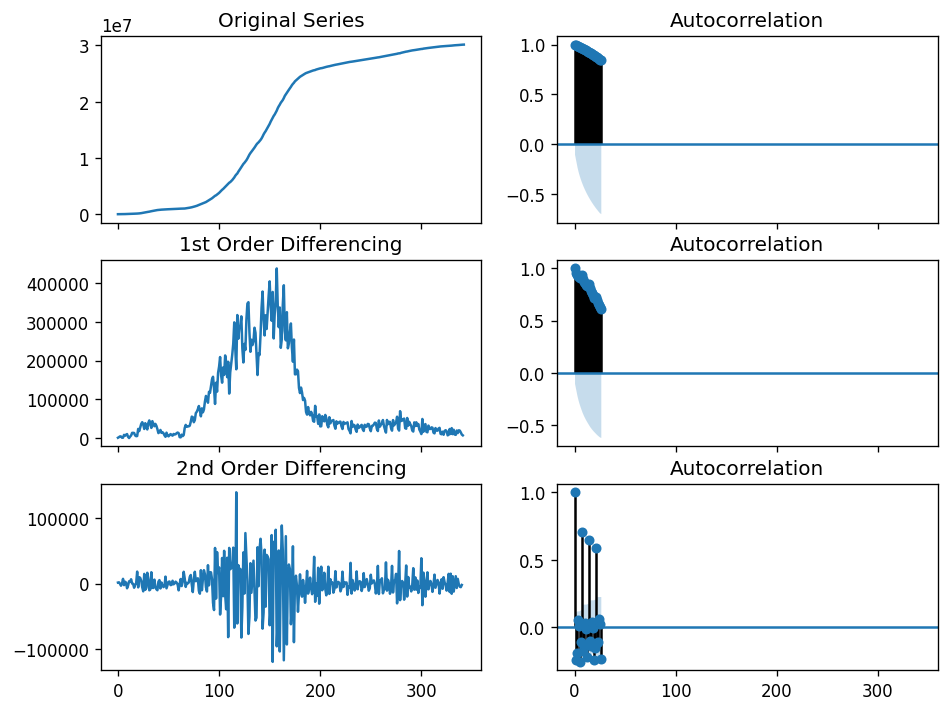

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
plt.show()

After doing 2nd order differencing, most autocorrelation value is inside the light blue region and most of the time series data plotted is between 0; we can conclude that the time series is stationary now. 

Also, we will confirm d=2 is needed next.

In [ ]:
!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True, 
alpha=0.005)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=7934.025, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7986.414, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=7966.708, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=7943.853, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7984.420, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=7931.500, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=7942.268, Time=0.06 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=7933.475, Time=0.25 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=7925.725, Time=0.91 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=7926.622, Time=0.40 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=7927.246, Time=0.73 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=7878.765, Time=1.21 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=7929.955, Time=0.41 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=7867.094, Time=1.14 sec
 ARIMA(3,2,3)(0,0,0)[0]          

The best model chosen is : ARIMA (p,d,q) = ARIMA(3,2,3). p-value is very tiny close to 0 as shown, which is what are happy to see.

As we assumed, second order differencing has to be performed for making the time series stationary in this scenario.

As the next step, perform diagnostic check for the residual as given below:

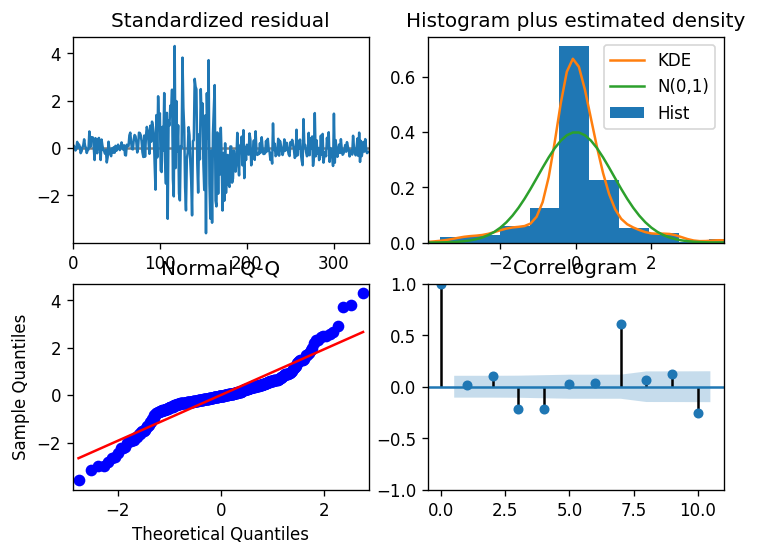

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

From the plot of Standardized residual, the standard deviation is not very high, and almost convergence to 0, which is good.

From the plot of the Histogram plus estimated density, the distribution of the residual is very similar to the normal distribution. The blue bar is the residual; most of them are 0 or very low, which means my prediction is close to the observation value.

From the plot of Normal Q-Q, the sample quantiles and theoretical quantiles are in good shape, which follows the same direction; the distribution of the model is similar to the normal distribution.

The plot of the Correlogram is autocorrelation for the residual error. We can see that most points are inside the region; then, we drive most of the pattern inside the model. Thus, the model captures most of the patterns.

The model is very great in general which can predict the value based on the observation. 


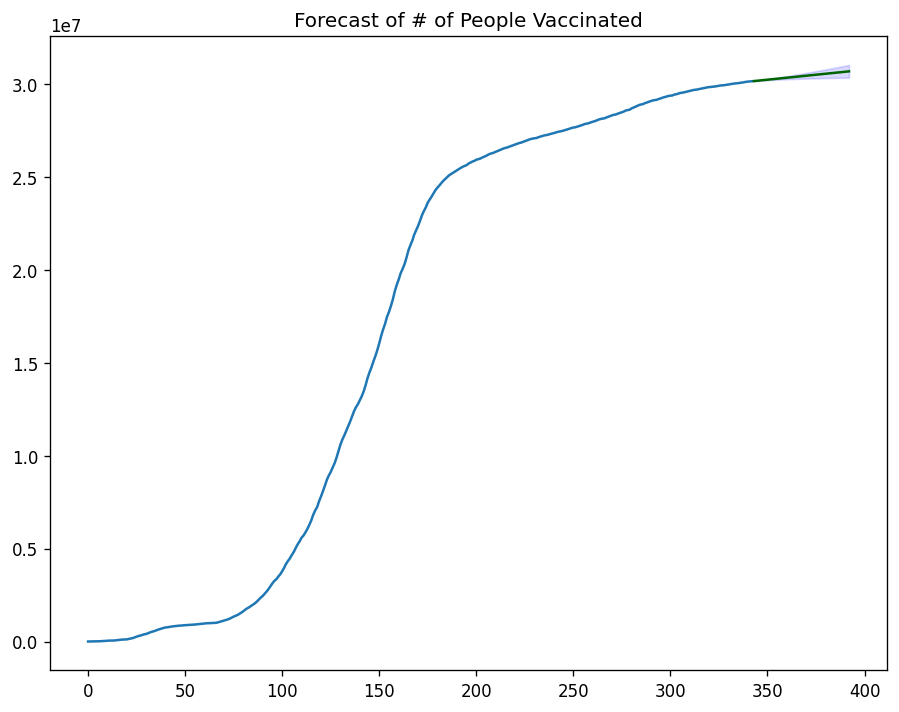

In [ ]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True, alpha = 0.9)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of # of People Vaccinated")
plt.show()

The worst case, base case, and best case are are all increasing; we forecast there is a higher vaccination rate in the next 50 days at a relatively slow and stable growth rate in Canada. 

# United States

In [ ]:
print('eid of United States is', list(df.loc[df.location == 'United States'].eid)[0])
ndf=df.loc[df['eid'] == 223]
sndf = ndf.sort_values('date')
# Check dataframe of United States
sndf.head()

eid of United States is 223


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,eid
59528,United States,USA,2020-12-13,21800.0,18529.0,3875.0,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.000,223
59529,United States,USA,2020-12-14,26124.0,22716.0,3971.0,0.0,4324.0,4324.0,0.01,0.01,0.0,0.0,13.0,4187.0,0.001,223
59530,United States,USA,2020-12-15,74833.0,69226.0,4166.0,0.0,48709.0,26516.0,0.02,0.02,0.0,0.0,79.0,25348.0,0.008,223
59531,United States,USA,2020-12-16,233645.0,222604.0,4548.0,0.0,158812.0,70615.0,0.07,0.07,0.0,0.0,210.0,68025.0,0.020,223
59532,United States,USA,2020-12-17,504183.0,486107.0,5110.0,0.0,270538.0,120596.0,0.15,0.14,0.0,0.0,359.0,116894.0,0.035,223


In [ ]:
# Get the values from the column where vaccination rate of United States is stored.
val = sndf['people_vaccinated'].values
val

array([1.85290000e+04, 2.27160000e+04, 6.92260000e+04, 2.22604000e+05,
       4.86107000e+05, 8.90820000e+05, 1.06788100e+06, 1.17028900e+06,
       1.54468000e+06, 1.98467200e+06, 2.54552900e+06, 2.73652100e+06,
       2.74903800e+06, 2.88722000e+06, 2.98089600e+06, 3.55645700e+06,
       4.25644000e+06, 5.07760800e+06, 5.48947100e+06, 5.56749200e+06,
       5.82037500e+06, 5.95027900e+06, 6.54329900e+06, 7.26878000e+06,
       8.09624200e+06, 8.95879400e+06, 9.80275700e+06, 1.01722220e+07,
       1.03475100e+07, 1.10698920e+07, 1.19823010e+07, 1.30098000e+07,
       1.41623670e+07, 1.52860470e+07, 1.58590700e+07, 1.61162250e+07,
       1.67554750e+07, 1.77285830e+07, 1.89057820e+07, 2.02534940e+07,
       2.16463740e+07, 2.23907750e+07, 2.26937550e+07, 2.35542390e+07,
       2.46083500e+07, 2.58588640e+07, 2.72284990e+07, 2.86028480e+07,
       2.93675120e+07, 2.96946880e+07, 3.04589550e+07, 3.14217990e+07,
       3.26849170e+07, 3.40759790e+07, 3.54397040e+07, 3.62949120e+07,
      

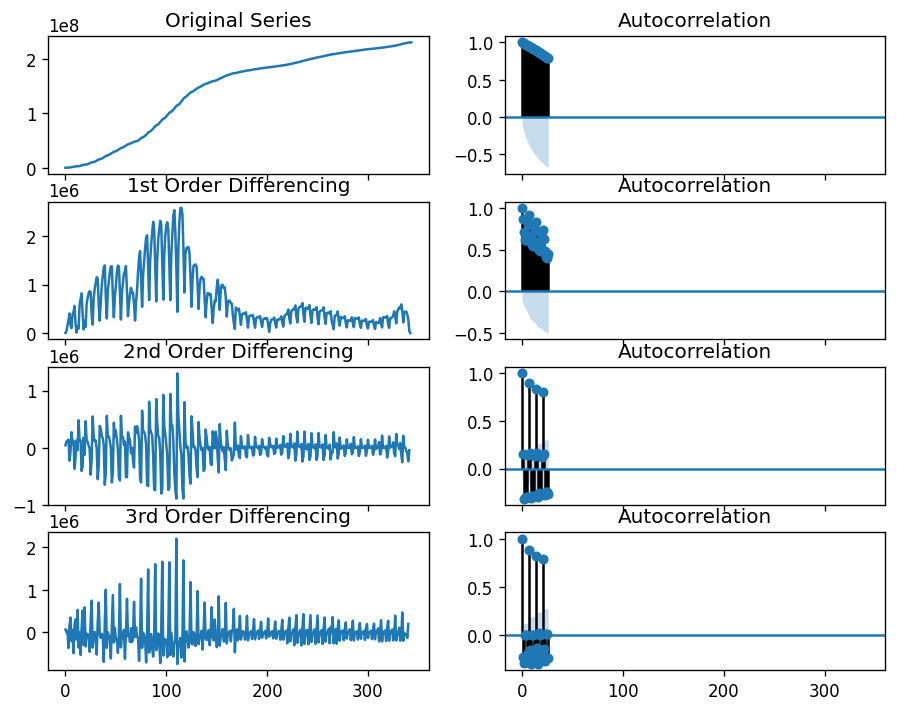

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1])
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1])
diff2val = np.diff(diffval)


# 3rd Differencing
axes[3, 0].plot(np.diff(diff2val)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diff2val), ax=axes[3, 1])
diff2val = np.diff(diff2val)
plt.show()

After doing 2nd order differencing, most of autocorrelation value is inside the light blue region; however, after 3rd order differencing, more autocorrelation value is inside the light blue region and most of the time series data plotted is between 0; we can conclude that the time series is stationary now. 

Also, we will confirm d=2 or 3 next.

In [ ]:
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=None, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9525.162, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9565.815, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9559.425, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9549.936, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9563.821, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9437.555, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9517.051, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9430.940, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=9502.925, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=9485.820, Time=0.60 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=9561.362, Time=0.39 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=9428.916, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=9435.524, Time=0.10 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9500.924, Time=0.07 sec
 ARIMA(3,2,2)(0,0,0)[0]          

The best model chosen is : ARIMA (p,d,q) = ARIMA(3,2,1).

Surprisingly, second order differencing (d = 2) has to be performed only instead of thrid for making the time series stationary in this scenario. Maybe in second order differencing, the time series can be determined as stationary; third order differencing does not necessary.

As the next step, perform diagnostic check for the residual as given below:

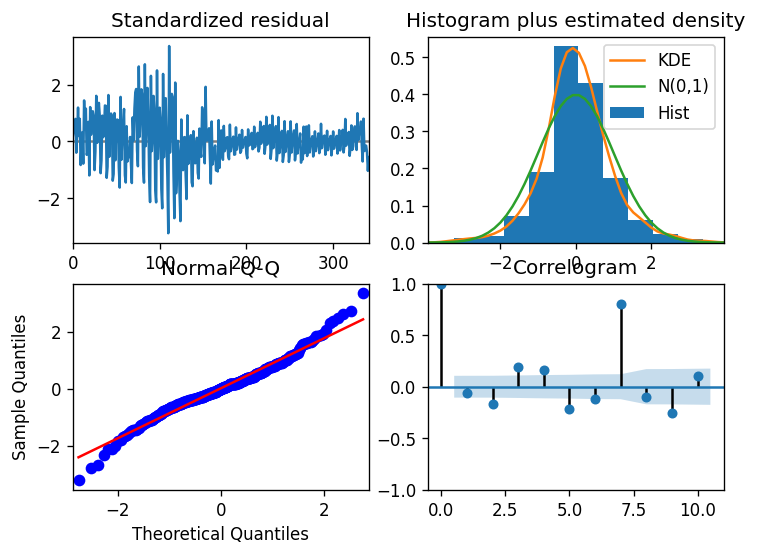

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

From the plot of Standardized residual, the standard deviation is not very high, most standard deviation is 0, and it is almost convergence to 0, which is good.

From the plot of the Histogram plus estimated density, the distribution of the residual is very similar to the normal distribution. The blue bar is the residual; most of them are 0 or very low, which means my prediction is close to the observation value.

From the plot of Normal Q-Q, the sample quantiles and theoretical quantiles are in good shape, which follows the same direction; the distribution of the model is similar to the normal distribution.

The plot of the Correlogram is autocorrelation for the residual error. We can see that not many points are inside the region; we cannot say we drive most of the pattern inside the model; maybe the model cannot capture most of the patterns. The reason maybe the model only performed 2nd order differencing, I think it may did 3nd to ensure the time series is stationary(d = 3) as I plotted before.

The model is very great in general which can predict the value based on the observation.

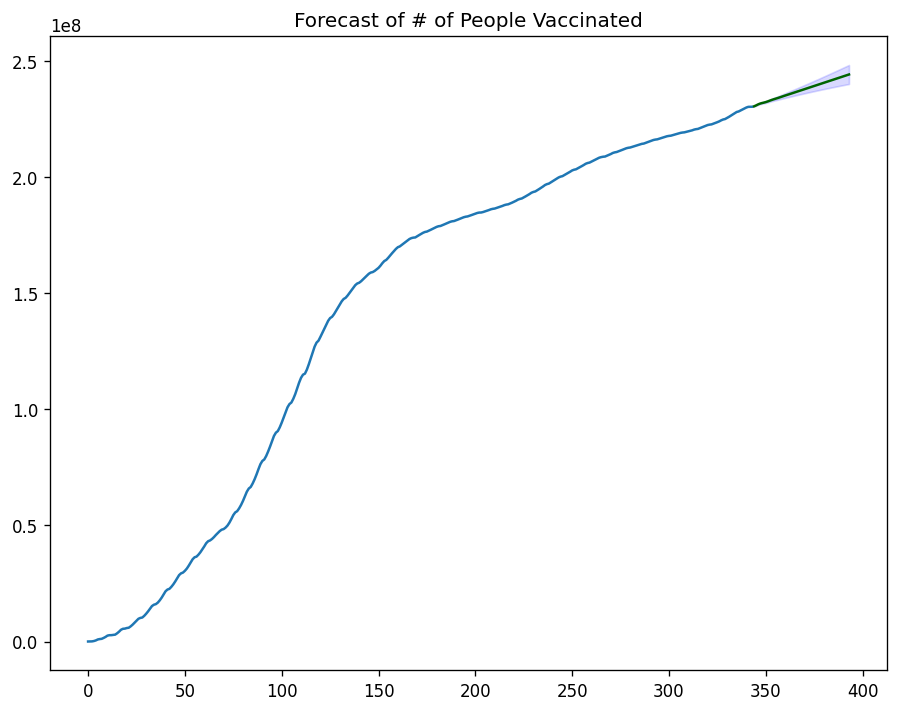

In [ ]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True, alpha = 0.8)
index_of_fc = np.arange(len(val), len(val)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(val)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of # of People Vaccinated")
plt.show()

Similarly to Canada, the worst case, base case, and best case are are all increasing; we forecast there is a higher vaccination rate in the next 50 days at a linearly increasing rate. By comparison, we predict that the vaccination rate of the United States will be lower than the rate of Canada.

# 4

In [ ]:
# Load the data set
c_df = pd.read_csv('Complete_covid19_dataset.csv')
c_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [ ]:
c_df.info(verbose=True)  # Cheak the columns of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134459 entries, 0 to 134458
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    134459 non-null  object 
 1   continent                                   125881 non-null  object 
 2   location                                    134459 non-null  object 
 3   date                                        134459 non-null  object 
 4   total_cases                                 127066 non-null  float64
 5   new_cases                                   127064 non-null  float64
 6   new_cases_smoothed                          126021 non-null  float64
 7   total_deaths                                115885 non-null  float64
 8   new_deaths                                  116081 non-null  float64
 9   new_deaths_smoothed                         126021 non-null  float64
 

In this part, I want to analyze the number of patients in hospitals associated with COVID-19 vaccination rates in Canada and the United States. So, the first thing is to fill the missing value for the column hosp_patients in the dataset.

In [ ]:
# Check out if we have any missing data in our dataset.
# pd.set_option("display.max_rows",None,"display.max_columns",None,"display.max_colwid",None)
c_df.isna().sum()

iso_code                                           0
continent                                       8578
location                                           0
date                                               0
total_cases                                     7393
new_cases                                       7395
new_cases_smoothed                              8438
total_deaths                                   18574
new_deaths                                     18378
new_deaths_smoothed                             8438
total_cases_per_million                         8045
new_cases_per_million                           8047
new_cases_smoothed_per_million                  9085
total_deaths_per_million                       19213
new_deaths_per_million                         19017
new_deaths_smoothed_per_million                 9085
reproduction_rate                              29478
icu_patients                                  118315
icu_patients_per_million                      

As can be seen, there is quite much missing data. Let's drop total_vaccinations missing data, as without this value any raw doesn't make much sense.

In [ ]:
c_df = c_df.drop(c_df[c_df.total_vaccinations.isna()].index)
c_df.isna().sum() # The number of missing value of total_vaccinations is 0 after drop the rows.

iso_code                                          0
continent                                      3902
location                                          0
date                                              0
total_cases                                    1767
new_cases                                      1769
new_cases_smoothed                             1768
total_deaths                                   1910
new_deaths                                     1912
new_deaths_smoothed                            1768
total_cases_per_million                        1767
new_cases_per_million                          1769
new_cases_smoothed_per_million                 1768
total_deaths_per_million                       1910
new_deaths_per_million                         1912
new_deaths_smoothed_per_million                1768
reproduction_rate                              6483
icu_patients                                  26736
icu_patients_per_million                      26736
hosp_patient

In [ ]:
c_check_df = c_df.drop(c_df[c_df.people_vaccinated.isna()].index)
c_check_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
364,AFG,Asia,Afghanistan,2021-02-22,55617.0,13.0,14.714,2433.0,1.0,0.857,1396.169,0.326,0.369,61.076,0.025,0.022,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
370,AFG,Asia,Afghanistan,2021-02-28,55714.0,7.0,15.714,2443.0,0.0,1.571,1398.604,0.176,0.394,61.327,0.000,0.039,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8200.0,8200.0,NaN,NaN,NaN,1367.0,0.02,0.02,NaN,NaN,34.0,1367.0,0.003,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
386,AFG,Asia,Afghanistan,2021-03-16,55995.0,10.0,17.000,2460.0,1.0,1.286,1405.658,0.251,0.427,61.754,0.025,0.032,1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54000.0,54000.0,NaN,NaN,NaN,2862.0,0.14,0.14,NaN,NaN,72.0,2862.0,0.007,30.56,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
408,AFG,Asia,Afghanistan,2021-04-07,56873.0,94.0,59.857,2512.0,0.0,4.000,1427.699,2.360,1.503,63.059,0.000,0.100,1.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120000.0,120000.0,NaN,NaN,NaN,3000.0,0.30,0.30,NaN,NaN,75.0,3000.0,0.008,26.85,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
423,AFG,Asia,Afghanistan,2021-04-22,58312.0,98.0,111.143,2561.0,4.0,4.000,1463.823,2.460,2.790,64.290,0.100,0.100,1.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240000.0,240000.0,NaN,NaN,NaN,8000.0,0.60,0.60,NaN,NaN,201.0,8000.0,0.020,26.85,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [ ]:
c_check_df[['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters']][0:10]

,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters
364,0.0,0.0,NaN,NaN
370,8200.0,8200.0,NaN,NaN
386,54000.0,54000.0,NaN,NaN
408,120000.0,120000.0,NaN,NaN
423,240000.0,240000.0,NaN,NaN
442,504502.0,448878.0,55624.0,NaN
451,547901.0,470341.0,77560.0,NaN
455,573277.0,476367.0,96910.0,NaN
457,590454.0,479372.0,111082.0,NaN
458,593313.0,479574.0,113739.0,NaN


As can bee seen from our data, the values of 'total_vaccinations' = 'people_vaccinated'+'people_fully_vaccinated'+'total_boosters' when missing values of 'people_fully_vaccinated' and 'total_boosters' are 0. Let's check the correlation to understand if it is so. 

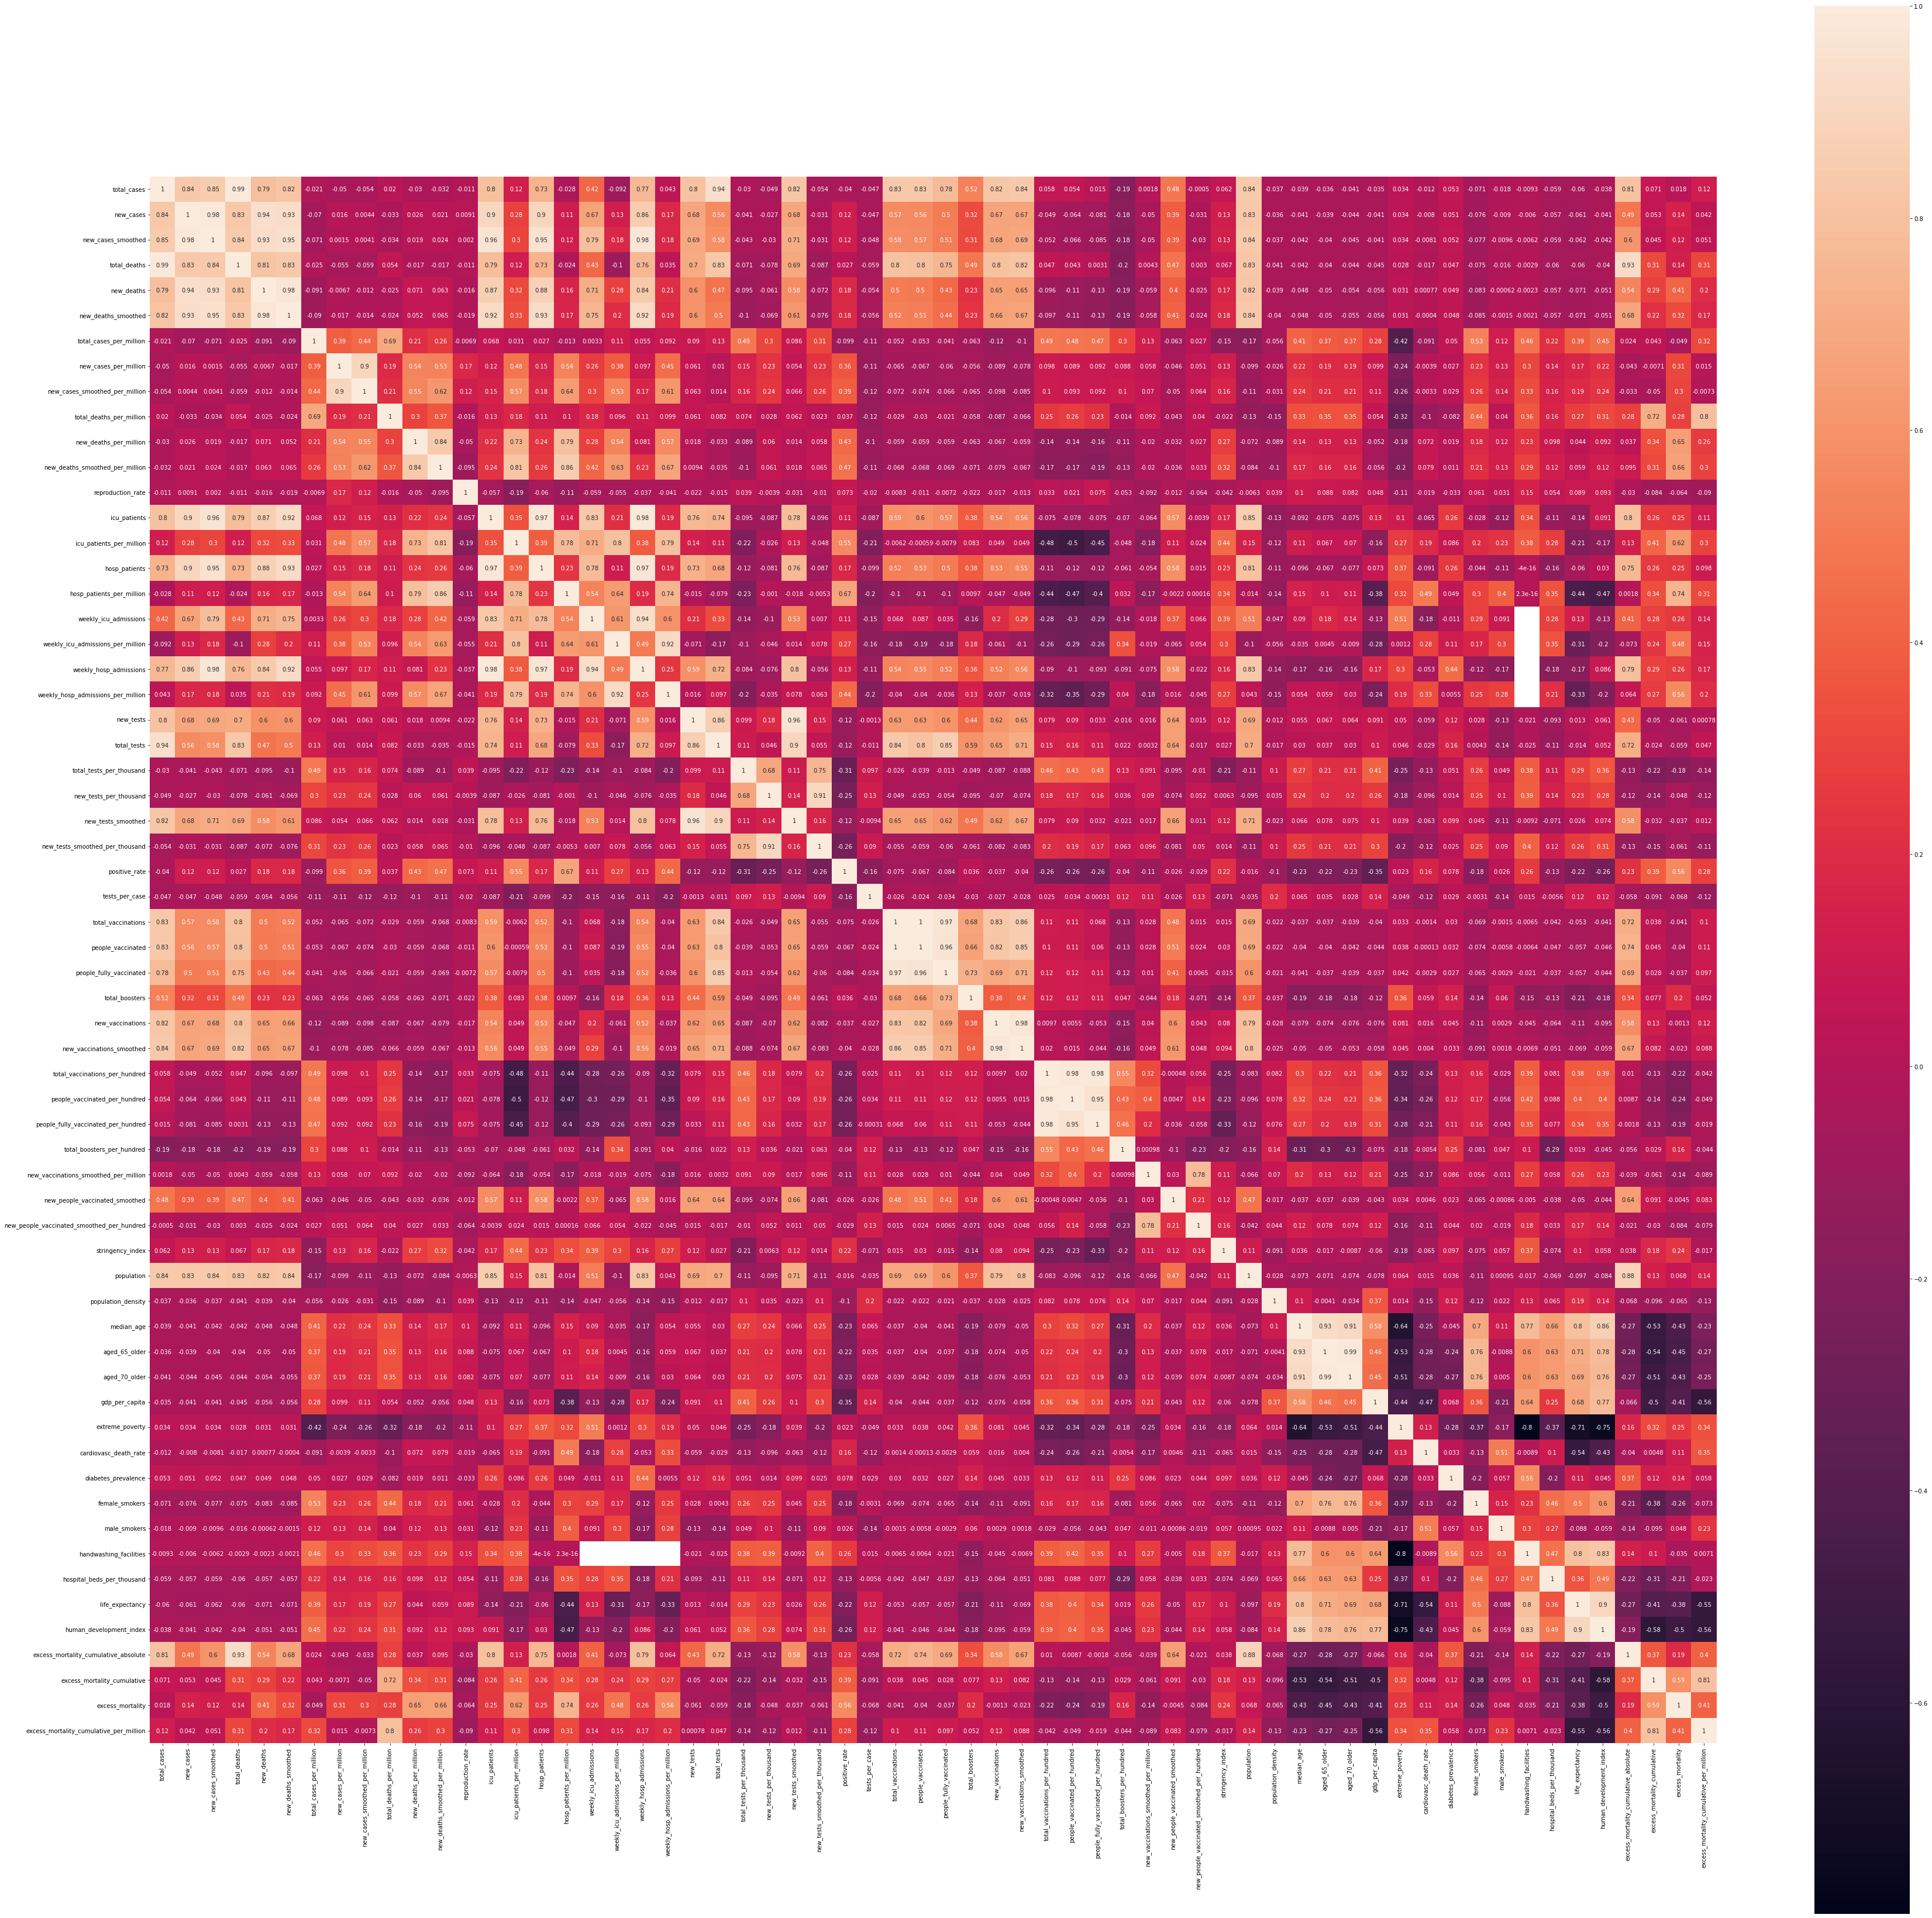

In [ ]:
#correlation matrix
plt.subplots(figsize=(60, 60))
sns.heatmap(c_check_df.corr(), annot=True, square=True)
plt.show()

From the correlation matrix, we can see'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters' are very corrlated with each other as we expected, then I replace missing values of 'people_fully_vaccinated' and 'total_boosters' with 0; then, fill the missing values of people_vaccinated based on the equation.

In [ ]:
# Fill 0 for 'people_fully_vaccinated', 'total_boosters' 
c_df.people_fully_vaccinated = c_df.people_fully_vaccinated.fillna(0)
c_df.total_boosters = c_df.total_boosters.fillna(0)
# Fill people_vaccinated 
c_df.people_vaccinated = c_df.people_vaccinated.fillna(c_df.total_vaccinations - c_df.people_fully_vaccinated - c_df.total_boosters)

# Check # nan
c_df.isna().sum()

iso_code                                          0
continent                                      3902
location                                          0
date                                              0
total_cases                                    1767
new_cases                                      1769
new_cases_smoothed                             1768
total_deaths                                   1910
new_deaths                                     1912
new_deaths_smoothed                            1768
total_cases_per_million                        1767
new_cases_per_million                          1769
new_cases_smoothed_per_million                 1768
total_deaths_per_million                       1910
new_deaths_per_million                         1912
new_deaths_smoothed_per_million                1768
reproduction_rate                              6483
icu_patients                                  26736
icu_patients_per_million                      26736
hosp_patient

For the rest of the columns which contain numbers, let's check the hypothesis that these columns distributions are the same. We apply normalization(avoid scaling problem) and Mann-Whitney U test, check the p_values. 
- p <= 0.05: reject H0, different distribution.
- p > 0.05: fail to reject H0, same distribution.

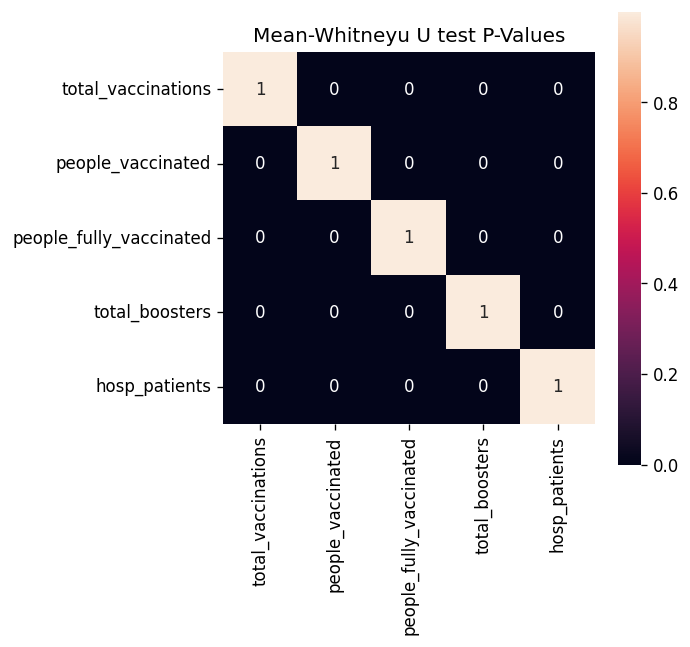

In [ ]:
list_columns = ['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'hosp_patients']
temp = []
for i in list_columns:
  temp2 = []
  temp_scale = StandardScaler()
  temp_scale2 = StandardScaler()
  for j in list_columns:
    check_dfi = c_check_df[i].dropna() # Drop NA item for the feature column before do Mann-Whiney U test each time.
    check_dfj = c_check_df[j].dropna()
    temp2.append(mannwhitneyu(temp_scale.fit_transform(check_dfi.values.reshape(-1,1)),
                              temp_scale2.fit_transform(check_dfj.values.reshape(-1,1)), alternative='two-sided')[1])
  temp.append(temp2)

plt.subplots(figsize=(5, 5))
sns.heatmap(temp, annot=True, square=True, yticklabels = list_columns, xticklabels = list_columns)
plt.title('Mean-Whitneyu U test P-Values')
plt.show()

After Mann-Whitney U test, check the p_values. 
All p-values < 0.05, then we conclude those features have different distribution. Thus, we fill missing values for hos_patients with 0. As we only need the columns of people_vaccinated and hosp_patients, we clean those features is enough.

In [ ]:
# Fill 0 for 'hosp_patients' 
c_df.hosp_patients = c_df.hosp_patients.fillna(0)

# Check # nan items in people_vaccinated
c_df.isna().sum()

iso_code                                          0
continent                                      3902
location                                          0
date                                              0
total_cases                                    1767
new_cases                                      1769
new_cases_smoothed                             1768
total_deaths                                   1910
new_deaths                                     1912
new_deaths_smoothed                            1768
total_cases_per_million                        1767
new_cases_per_million                          1769
new_cases_smoothed_per_million                 1768
total_deaths_per_million                       1910
new_deaths_per_million                         1912
new_deaths_smoothed_per_million                1768
reproduction_rate                              6483
icu_patients                                  26736
icu_patients_per_million                      26736
hosp_patient

We want to add a new a column named 'eid', each location would have a unique number. For example, each row for location Afghanistan lebeled as 1 in the column of eid.

In [ ]:
# Sort the df by location
c_df = c_df.sort_values('location')
# Number each item in each group from 0 to the length of that group - 1, 
# first item with for each location lebeled as 1, other row labeled as 0
c_df['eid'] = (c_df.groupby(['location']).cumcount()==0).astype(int)
# Each location have a unique number by order
c_df['eid'] = c_df['eid'].cumsum()
c_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
364,AFG,Asia,Afghanistan,2021-02-22,55617.0,13.0,14.714,2433.0,1.0,0.857,1396.169,0.326,0.369,61.076,0.025,0.022,0.85,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,12.04,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1
629,AFG,Asia,Afghanistan,2021-11-14,156552.0,42.0,22.143,7293.0,1.0,1.286,3929.969,1.054,0.556,183.078,0.025,0.032,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4018197.0,3530173.0,3188609.0,0.0,NaN,36635.0,10.09,8.86,8.00,NaN,920.0,60035.0,0.151,NaN,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1
584,AFG,Asia,Afghanistan,2021-09-30,155174.0,46.0,53.429,7204.0,0.0,0.714,3895.377,1.155,1.341,180.844,0.000,0.018,0.85,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2369625.0,828601.0,0.0,0.0,NaN,12999.0,5.95,2.08,NaN,NaN,326.0,1853.0,0.005,35.19,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1
554,AFG,Asia,Afghanistan,2021-08-31,153220.0,72.0,80.000,7118.0,2.0,5.000,3846.325,1.807,2.008,178.685,0.050,0.126,0.75,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1979652.0,773002.0,0.0,0.0,NaN,70761.0,4.97,1.94,NaN,NaN,1776.0,224.0,0.001,18.52,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1
543,AFG,Asia,Afghanistan,2021-08-20,152448.0,37.0,96.857,7054.0,7.0,7.714,3826.945,0.929,2.431,177.079,0.176,0.194,0.64,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1201286.0,770542.0,430744.0,0.0,NaN,1119.0,3.02,1.93,1.08,NaN,28.0,690.0,0.002,22.22,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN,1


I want to find the relationship between hospitalizations and number of people vaccinated based on some plots for two countries, Canada and United States

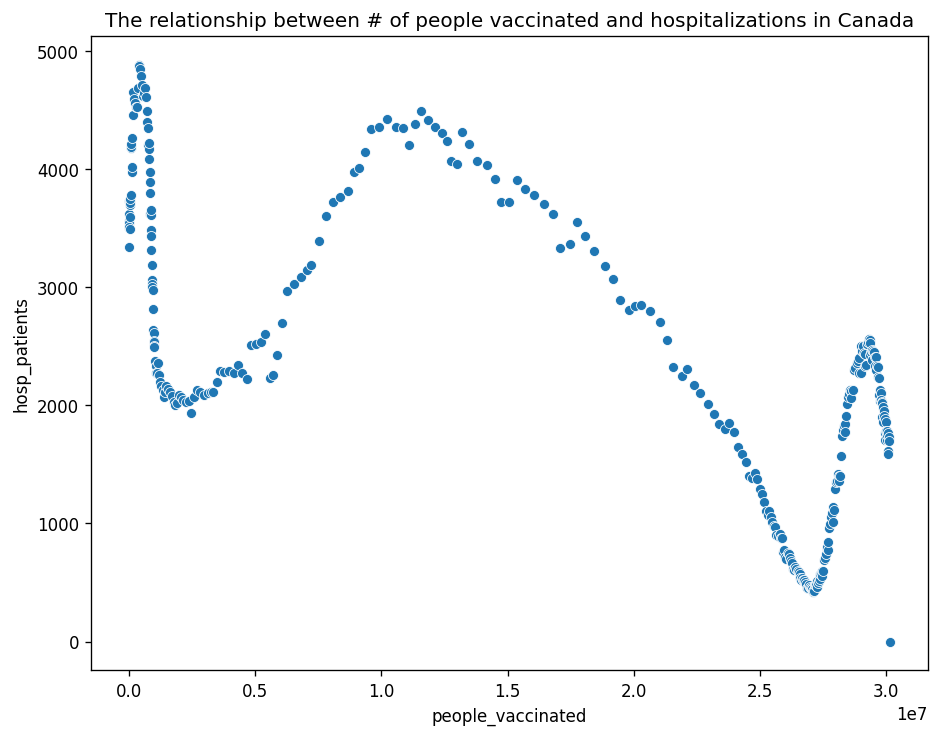

In [ ]:
ax = plt.axes()
sns.scatterplot(data=sndf1, x='people_vaccinated', y='hosp_patients')
ax.set_title('The relationship between # of people vaccinated and hospitalizations in Canada')
plt.show()

Although the tread experienced some fluctuations, in general, when more people get vaccinated, the number of patients in the hospital decreased a lot. We can conclude that COVID-19 Vaccination is useful to decrease hospitalizations in Canada. 

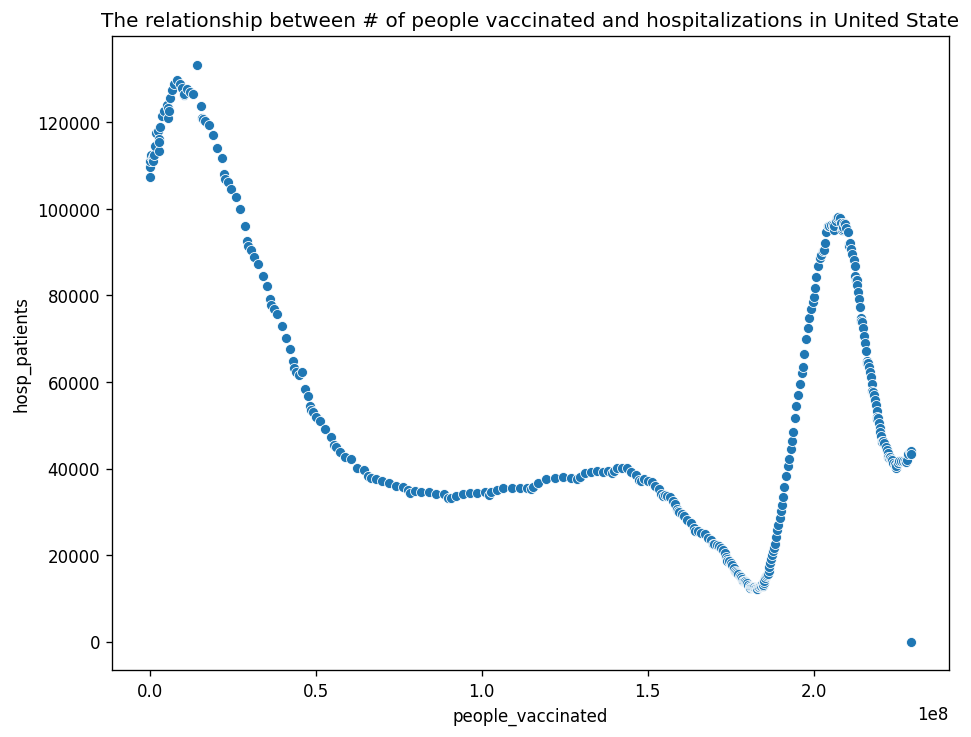

In [ ]:
ax = plt.axes()
sns.scatterplot(data=sndf2, x='people_vaccinated', y='hosp_patients')
ax.set_title('The relationship between # of people vaccinated and hospitalizations in United State')
plt.show()

Although the tread experienced some fluctuations, in general, when more people get vaccinated, the number of patients in the hospital decreased a lot. We can conclude that COVID-19 Vaccination is useful to decrease hospitalizations in the United States. 

I want to find the correlation between hospitalizations and number of people vaccinated based Pearsonr for two countries, Canada and United States

# Canada

In [ ]:
print('eid of Canada is', list(c_df.loc[c_df.location == 'Canada'].eid)[0])
ndf=c_df.loc[c_df['eid'] == 38]
sndf1 = ndf.sort_values('date')
# Check dataframe of Canada
sndf1.head()

eid of Canada is 38


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
21633,CAN,North America,Canada,2020-12-14,474661.0,8645.0,6658.143,13677.0,140.0,111.571,12468.795,227.094,174.902,359.279,3.678,2.931,1.05,685.0,17.994,3335.0,87.607,NaN,NaN,NaN,NaN,131408.0,16008664.0,420.529,3.452,126618.0,3.326,0.053,19.0,tests performed,5.0,5.0,0.0,0.0,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21634,CAN,North America,Canada,2020-12-15,480952.0,6291.0,6661.714,13793.0,116.0,114.286,12634.052,165.257,174.996,362.326,3.047,3.002,1.04,704.0,18.493,3499.0,91.915,NaN,NaN,NaN,NaN,123736.0,16132400.0,423.779,3.250,128820.0,3.384,0.052,19.3,tests performed,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,NaN,NaN,19.0,722.0,0.002,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21635,CAN,North America,Canada,2020-12-16,487685.0,6733.0,6706.857,13911.0,118.0,114.571,12810.920,176.868,176.181,365.426,3.100,3.010,1.04,720.0,18.914,3549.0,93.228,NaN,NaN,NaN,NaN,96979.0,16229379.0,426.327,2.548,128724.0,3.381,0.052,19.2,tests performed,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,NaN,NaN,40.0,1506.0,0.004,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21636,CAN,North America,Canada,2020-12-17,495152.0,7467.0,6830.143,14067.0,156.0,120.000,13007.070,196.149,179.420,369.524,4.098,3.152,1.04,720.0,18.914,3556.0,93.412,NaN,NaN,NaN,NaN,127245.0,16356624.0,429.670,3.343,129656.0,3.406,0.053,19.0,tests performed,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,NaN,NaN,64.0,2421.0,0.006,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38
21637,CAN,North America,Canada,2020-12-18,502197.0,7045.0,6849.000,14180.0,113.0,117.857,13192.134,185.064,179.915,372.492,2.968,3.096,1.03,722.0,18.966,3506.0,92.099,NaN,NaN,NaN,NaN,136648.0,16493272.0,433.259,3.590,129786.0,3.409,0.053,18.9,tests performed,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,NaN,NaN,74.0,2818.0,0.007,70.83,38067913.0,4.037,41.4,16.984,10.797,44017.591,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN,NaN,NaN,NaN,38


In [ ]:
from scipy import stats
correlation, p_value = stats.pearsonr(sndf1.hosp_patients, sndf1.people_vaccinated)
print('The correlation between between hospitalizations and number of people vaccinated in Canada is', correlation)

The correlation between between hospitalizations and number of people vaccinated in Canada is -0.672370688463855


The correlation between hospitalizations and the number of people vaccinated in Canada is -0.67 determines that # people vaccinated are very correlated with hospitalizations; when # people vaccinated increases, hospitalizations in Canada decrease effectively.

# United States

In [ ]:
print('eid of United States is', list(c_df.loc[c_df.location == 'United States'].eid)[0])
ndf=c_df.loc[c_df['eid'] == 220]
sndf2 = ndf.sort_values('date')
# Check dataframe of United States
sndf2.head()

eid of United States is 220


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,eid
127218,USA,North America,United States,2020-12-13,16471966.0,186705.0,218005.714,303465.0,1659.0,2554.571,49477.982,560.819,654.839,911.539,4.983,7.673,1.06,25074.0,75.317,107402.0,322.611,NaN,NaN,101588.0,305.147,1248569.0,227127936.0,682.240,3.750,1826484.0,5.486,0.119,8.4,tests performed,21634.0,18389.0,3847.0,0.0,NaN,NaN,0.01,0.01,0.0,NaN,NaN,NaN,NaN,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,394357.9,14.13,39.73,1184.56006,220
127219,USA,North America,United States,2020-12-14,16672597.0,200631.0,219503.000,305114.0,1649.0,2567.429,50080.631,602.649,659.336,916.492,4.953,7.712,1.06,25560.0,76.776,109689.0,329.480,NaN,NaN,NaN,NaN,1493348.0,228621284.0,686.726,4.486,1819858.0,5.466,0.121,8.3,tests performed,25954.0,22572.0,3943.0,0.0,4320.0,4320.0,0.01,0.01,0.0,NaN,13.0,4183.0,0.001,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,220
127220,USA,North America,United States,2020-12-15,16894649.0,222052.0,218232.000,308101.0,2987.0,2625.143,50747.624,666.993,655.519,925.464,8.972,7.885,1.05,25812.0,77.533,110996.0,333.406,NaN,NaN,NaN,NaN,1944443.0,230565727.0,692.566,5.841,1824154.0,5.479,0.120,8.4,tests performed,74646.0,69067.0,4137.0,0.0,48692.0,26506.0,0.02,0.02,0.0,NaN,79.0,25339.0,0.008,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,220
127221,USA,North America,United States,2020-12-16,17135340.0,240691.0,221025.429,311834.0,3733.0,2704.000,51470.604,722.980,663.909,936.677,11.213,8.122,1.04,25974.0,78.020,112009.0,336.449,NaN,NaN,NaN,NaN,2076401.0,232642128.0,698.803,6.237,1817404.0,5.459,0.122,8.2,tests performed,233433.0,222420.0,4519.0,0.0,158787.0,70600.0,0.07,0.07,0.0,NaN,210.0,68010.0,0.020,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,220
127222,USA,North America,United States,2020-12-17,17372569.0,237229.0,221390.143,315284.0,3450.0,2770.286,52183.185,712.581,665.005,947.040,10.363,8.321,1.03,25894.0,77.780,112445.0,337.759,NaN,NaN,NaN,NaN,2052173.0,234694301.0,704.967,6.164,1798953.0,5.404,0.123,8.1,tests performed,503907.0,485867.0,5076.0,0.0,270474.0,120568.0,0.15,0.14,0.0,NaN,358.0,116870.0,0.035,71.76,332915074.0,35.608,38.3,15.413,9.732,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.926,NaN,NaN,NaN,NaN,220


In [ ]:
correlation, p_value = stats.pearsonr(sndf2.hosp_patients, sndf2.people_vaccinated)
print('The correlation between between hospitalizations and number of people vaccinated in United States is', correlation)

The correlation between between hospitalizations and number of people vaccinated in United States is -0.4820920863653119


The correlation between hospitalizations and the number of people vaccinated in the United States is -0.48 determines that # people vaccinated are very correlated with hospitalizations; when # people vaccinated increases, hospitalizations in the United States decrease a lot.

In conclusion, the increase of COVID-19 vaccination rates can reduce hospitalizations effectively.

# 5

# <center>Section 3 Findings</center>
|Country|Population(million)|Forecasting # people vaccinated in next 50 days (million)|Forecasting vaccination rate|
|-|-|-|-|
|Canada|37|33|89%|
|United States|335|250|74.6%|

# <center>Section 4 Findings</center>
|Country|Hospitalizations without vaccination|Forecasting hospitalizations in next 50 days|Reduced people hospitalized|
|-|-|-|-|
|Canada|3300|1200|63.6%|
|United States|105000|40000|60%|

By researching, the population of Canada is around 37 million, and that of the United States is about 335 million in June 2021. 

From Section 3, we forecast that around 33 million people will be vaccinated at least one vaccine dose in Canada and approximately 250 million people vaccinated at least one vaccine dose in the United States. Canadian vaccination rate （people vaccinated at least one dose）will reach 89%, while the United States will have only a 74.6% vaccination rate, which is lower than Canada. 


From Section 4, we can observe around 3300 people in hospitals in Canada without vaccination; the number of people in hospitals decreased to about 1200 as people vaccinated; vaccines have reduced the number of people hospitalized 63.6% in Canada. In the United States, there are around 105000 people in hospitals without vaccination; then, hospitalizations decreased to about 40000, which reduced people hospitalized by approximately 60%, lower than Canada. 

In addition, The correlation between hospitalizations and the number of people vaccinated in Canada is -0.67, and in the United States is -0.48. The signs of correlations are all negative; when more people are vaccinated, hospitalizations will decrease in both countries. The correlation has a higher absolute value in Canada than in the United States. In other words, Canada has a lower hospitalization rate than the United States when more people are vaccinated.

Thus, I conclude Canada has the most effective vaccination program because of the higher vaccination rate and lower hospitalization rates. 

However, from the result of the models, I can see the forecasted projections of the United States has a higher slope than that of Canada. In other words, the United States has a higher growth rate of people vaccinated than Canada in the next 50 days. We believe the US has overcome the COVID-19 pandemic actively; we should have an objective attitude towards the outbreak in the United States even it shows Canada has the most effective vaccination program. 